In [13]:
# COMPAS Bias Audit: Criminal Recidivism Prediction Analysis
# A comprehensive fairness analysis of the COMPAS algorithm

# ============================================================================
# SECTION 1: ENVIRONMENT SETUP AND DATA IMPORT
# ============================================================================

# Install required packages
#pip install aif360 fairlearn matplotlib seaborn plotly scikit-learn pandas numpy

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

# Fairness Libraries
from aif360.datasets import CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.postprocessing import EqOddsPostprocessing
%pip install tensorflow
#import tensorflow as tf

# Statistical Testing
from scipy import stats
from scipy.stats import chi2_contingency

print("All libraries imported successfully!")

Note: you may need to restart the kernel to use updated packages.
All libraries imported successfully!


ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [14]:
def load_compas_data():
    """Load and prepare COMPAS dataset"""
    # dataset = CompasDataset()
    # df = dataset.convert_to_dataframe()[0]

    # Alternative: Load from URL if AIF360 doesn't work
    url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
    df = pd.read_csv(url)

    # Return the dataframe and a placeholder for aif_dataset
    # Since we are loading directly from URL, we don't have an AIF360 dataset object
    return df, None

# Load the data
df, aif_dataset = load_compas_data()

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

Dataset loaded successfully!
Dataset shape: (7214, 53)

First few rows:
   id                name   first         last compas_screening_date   sex  \
0   1    miguel hernandez  miguel    hernandez            2013-08-14  Male   
1   3         kevon dixon   kevon        dixon            2013-01-27  Male   
2   4            ed philo      ed        philo            2013-04-14  Male   
3   5         marcu brown   marcu        brown            2013-01-13  Male   
4   6  bouthy pierrelouis  bouthy  pierrelouis            2013-03-26  Male   

          dob  age          age_cat              race  ...  v_decile_score  \
0  1947-04-18   69  Greater than 45             Other  ...               1   
1  1982-01-22   34          25 - 45  African-American  ...               1   
2  1991-05-14   24     Less than 25  African-American  ...               3   
3  1993-01-21   23     Less than 25  African-American  ...               6   
4  1973-01-22   43          25 - 45             Other  ...           

In [15]:
def explore_dataset(df):
    """Comprehensive exploration of the COMPAS dataset"""

    print("="*60)
    print("DATASET OVERVIEW")
    print("="*60)

    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"\nData types:\n{df.dtypes}")
    print(f"\nMissing values:\n{df.isnull().sum()}")

    # Basic statistics
    print("\n" + "="*60)
    print("BASIC STATISTICS")
    print("="*60)
    print(df.describe())

    # Target variable distribution
    if 'two_year_recid' in df.columns:
        target_col = 'two_year_recid'
    else:
        target_col = df.columns[-1]  # Assume last column is target

    print(f"\nTarget variable '{target_col}' distribution:")
    print(df[target_col].value_counts())
    print(f"Recidivism rate: {df[target_col].mean():.3f}")

    # Race distribution
    if 'race' in df.columns:
        print(f"\nRace distribution:")
        race_counts = df['race'].value_counts()
        print(race_counts)
        print(f"Percentage distribution:")
        print((race_counts / len(df) * 100).round(2))

    return target_col

target_col = explore_dataset(df) # Capture the returned target_col

DATASET OVERVIEW
Dataset shape: (7214, 53)
Columns: ['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob', 'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number', 'c_offense_date', 'c_arrest_date', 'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number', 'r_charge_degree', 'r_days_from_arrest', 'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid', 'is_violent_recid', 'vr_case_number', 'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc', 'type_of_assessment', 'decile_score.1', 'score_text', 'screening_date', 'v_type_of_assessment', 'v_decile_score', 'v_score_text', 'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1', 'start', 'end', 'event', 'two_year_recid']

Data types:
id                           int64
name                        object
first                       object

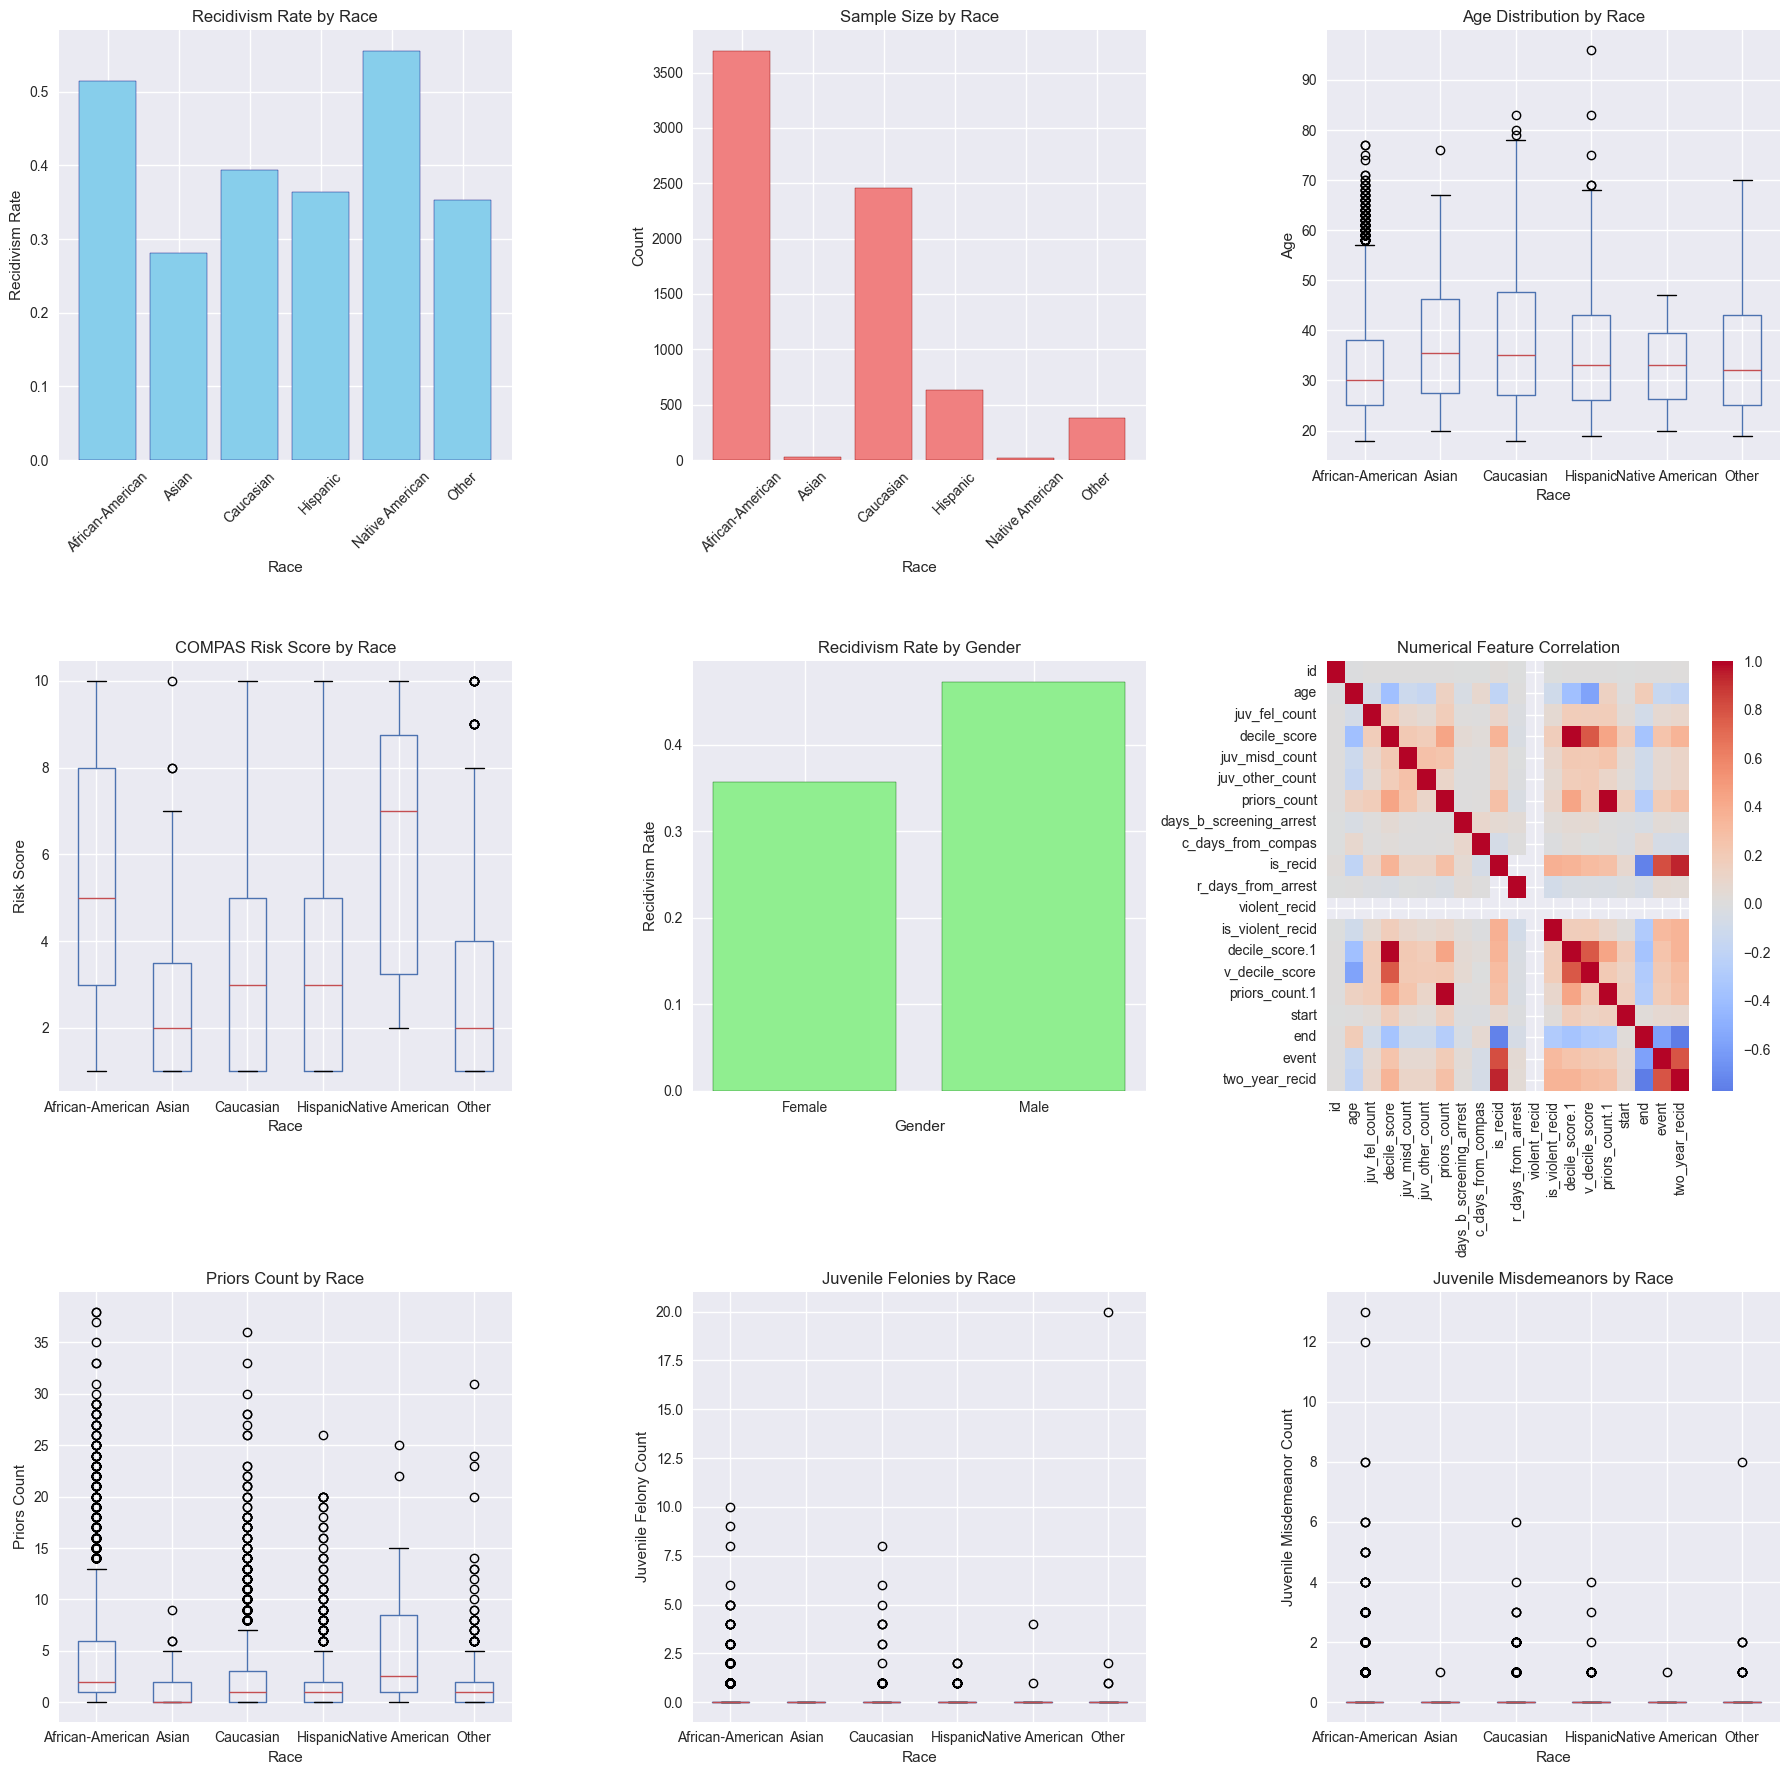

In [16]:
def create_bias_visualizations(df, target_col):
    """Create comprehensive visualizations to identify bias patterns"""

    # Set up the plotting style
    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(3, 3, figsize=(18, 18)) # Increased grid size for more plots
    fig.suptitle('COMPAS Dataset: Bias Pattern Analysis', fontsize=16, fontweight='bold')

    # Flatten axes array for easier indexing
    axes = axes.flatten()

    # 1. Recidivism by Race
    race_recid = df.groupby('race')[target_col].agg(['mean', 'count']).reset_index()
    axes[0].bar(race_recid['race'], race_recid['mean'], color='skyblue', edgecolor='navy')
    axes[0].set_title('Recidivism Rate by Race')
    axes[0].set_xlabel('Race')
    axes[0].set_ylabel('Recidivism Rate')
    axes[0].tick_params(axis='x', rotation=45)

    # 2. Sample size by race
    axes[1].bar(race_recid['race'], race_recid['count'], color='lightcoral', edgecolor='darkred')
    axes[1].set_title('Sample Size by Race')
    axes[1].set_xlabel('Race')
    axes[1].set_ylabel('Count')
    axes[1].tick_params(axis='x', rotation=45)

    # 3. Age distribution by race
    if 'age' in df.columns:
        df.boxplot(column='age', by='race', ax=axes[2])
        axes[2].set_title('Age Distribution by Race')
        axes[2].set_xlabel('Race')
        axes[2].set_ylabel('Age')
        plt.suptitle('') # Suppress the automatic suptitle from boxplot

    # 4. COMPAS scores by race (if available)
    if 'decile_score' in df.columns:
        df.boxplot(column='decile_score', by='race', ax=axes[3])
        axes[3].set_title('COMPAS Risk Score by Race')
        axes[3].set_xlabel('Race')
        axes[3].set_ylabel('Risk Score')
        plt.suptitle('') # Suppress the automatic suptitle from boxplot

    # 5. Gender distribution
    if 'sex' in df.columns:
        gender_recid = df.groupby('sex')[target_col].mean()
        axes[4].bar(gender_recid.index, gender_recid.values, color='lightgreen', edgecolor='darkgreen')
        axes[4].set_title('Recidivism Rate by Gender')
        axes[4].set_xlabel('Gender')
        axes[4].set_ylabel('Recidivism Rate')

    # 6. Correlation heatmap for numerical features
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 1:
        corr_matrix = df[numeric_cols].corr()
        sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, ax=axes[5]) # Reduced annot to False for clarity
        axes[5].set_title('Numerical Feature Correlation')

    # 7. Priors Count by Race (New Plot)
    if 'priors_count' in df.columns:
        df.boxplot(column='priors_count', by='race', ax=axes[6])
        axes[6].set_title('Priors Count by Race')
        axes[6].set_xlabel('Race')
        axes[6].set_ylabel('Priors Count')
        plt.suptitle('') # Suppress the automatic suptitle from boxplot

    # 8. Juvenile Felonies by Race (New Plot)
    if 'juv_fel_count' in df.columns:
        df.boxplot(column='juv_fel_count', by='race', ax=axes[7])
        axes[7].set_title('Juvenile Felonies by Race')
        axes[7].set_xlabel('Race')
        axes[7].set_ylabel('Juvenile Felony Count')
        plt.suptitle('') # Suppress the automatic suptitle from boxplot

    # 9. Juvenile Misdemeanors by Race (New Plot)
    if 'juv_misd_count' in df.columns:
        df.boxplot(column='juv_misd_count', by='race', ax=axes[8])
        axes[8].set_title('Juvenile Misdemeanors by Race')
        axes[8].set_xlabel('Race')
        axes[8].set_ylabel('Juvenile Misdemeanor Count')
        plt.suptitle('') # Suppress the automatic suptitle from boxplot


    plt.tight_layout()
    plt.show()

    return race_recid

# Create visualizations
race_stats = create_bias_visualizations(df, target_col)

# Task
Analyze the provided dataset to identify potential racial bias in predicting recidivism using a machine learning model. Specifically, train a model to predict recidivism and then generate and interpret confusion matrices for different racial groups to assess disparities in prediction accuracy.

## Data preparation for modeling

### Subtask:
Select relevant features, handle categorical variables (e.g., one-hot encoding 'race' and 'sex'), and split the data into training and testing sets.


**Reasoning**:
Create a new DataFrame with relevant features, handle missing values, perform one-hot encoding on categorical features, define features and target, and split the data into training and testing sets.



In [18]:
# 1. Create a new DataFrame with relevant features
df_model = df[['sex', 'age', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'two_year_recid']].copy()

# 2. Handle missing values
df_model.dropna(inplace=True)

# 3. Identify categorical columns
categorical_cols = ['sex', 'race']

# 4. Apply one-hot encoding
df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

# 5. Define features (X) and target variable (y)
X = df_model.drop('two_year_recid', axis=1)
y = df_model['two_year_recid']

# 6. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data processing and splitting complete.")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Data processing and splitting complete.
Shape of X_train: (5771, 11)
Shape of X_test: (1443, 11)
Shape of y_train: (5771,)
Shape of y_test: (1443,)


## Model selection and training

### Subtask:
Choose a model (e.g., Logistic Regression or RandomForestClassifier) and train it on the prepared training data to predict the target variable ('two_year_recid').


**Reasoning**:
Train a Logistic Regression model on the training data as instructed.



In [19]:
# 1. Instantiate a LogisticRegression model
model = LogisticRegression(random_state=42)

# 2. Train the model using the X_train and y_train dataframes
model.fit(X_train, y_train)

print("Logistic Regression model trained successfully.")

Logistic Regression model trained successfully.


## Prediction

### Subtask:
Use the trained model to make predictions on the test set.


**Reasoning**:
Use the trained Logistic Regression model to predict recidivism on the test dataset.



In [20]:
# Use the trained model to predict the target variable for the test set features
y_pred = model.predict(X_test)

print("Predictions on the test set generated successfully.")

Predictions on the test set generated successfully.


## Generate confusion matrices by race

### Subtask:
For each racial group, filter the test set, calculate the confusion matrix using the actual outcomes and the model's predictions for that group, and visualize the confusion matrix with a clear title indicating the race.


**Reasoning**:
Identify unique racial groups and iterate through them to filter the test data, calculate the confusion matrix, and visualize it for each group.



**Reasoning**:
The error indicates that the column name 'race_African-American' does not exist in the `X_test` DataFrame. This is likely due to the `drop_first=True` argument used during one-hot encoding, which drops the first category (alphabetically) for each feature. I need to check the columns in `X_test` and adjust the race column names accordingly, ensuring I handle the dropped first category. I will identify the one-hot encoded race columns in `X_test` and iterate through the original unique races, mapping them to the correct encoded column names or handling the base case appropriately.




Analyzing bias for the 'Other' group...


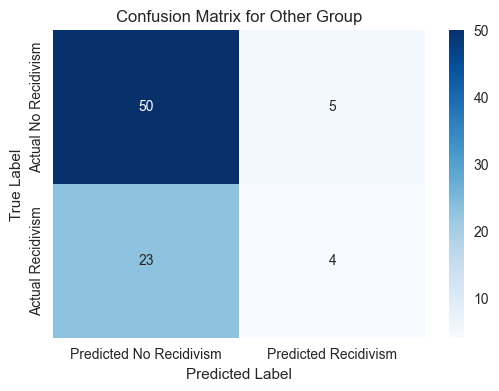


Analyzing bias for the 'African-American' group...


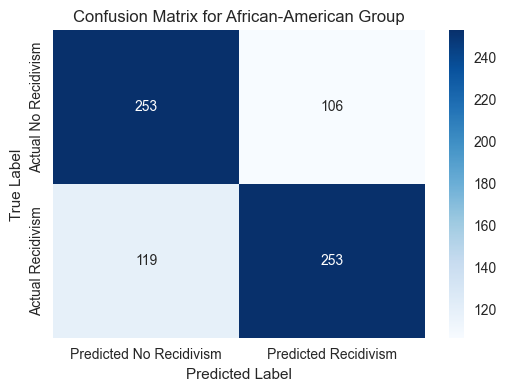


Analyzing bias for the 'Caucasian' group...


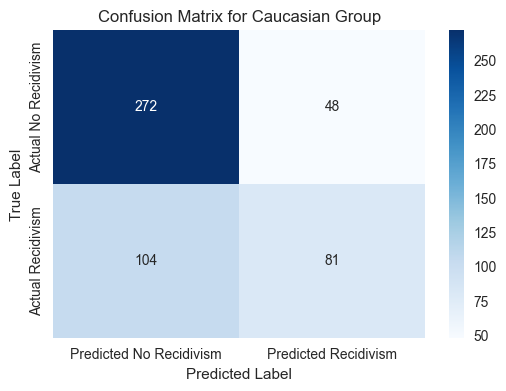


Analyzing bias for the 'Hispanic' group...


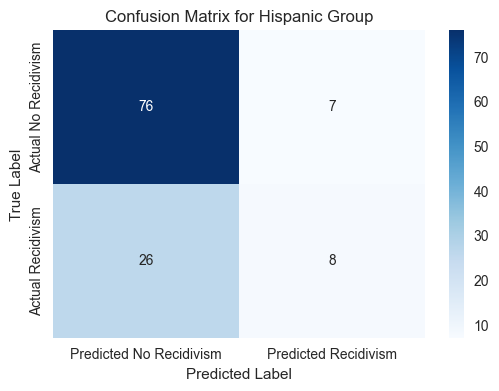


Analyzing bias for the 'Native American' group...


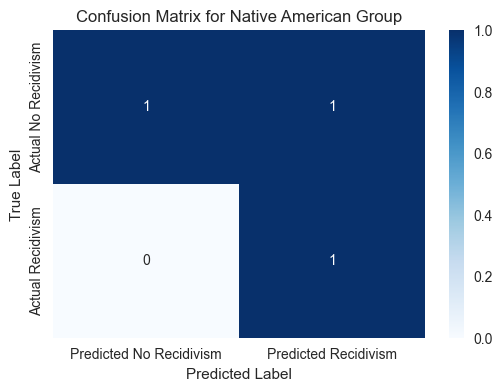


Analyzing bias for the 'Asian' group...


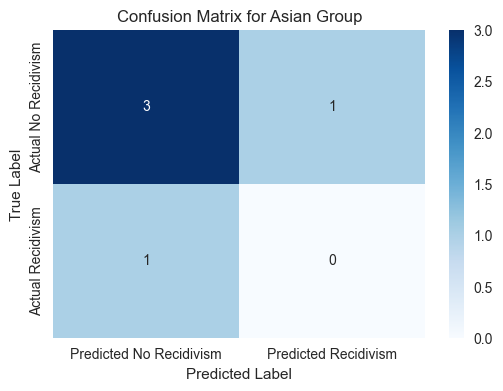

In [22]:
# Identify the one-hot encoded race columns in X_test
race_encoded_cols = [col for col in X_test.columns if col.startswith('race_')]

# Get unique races from the original dataframe
unique_races = df['race'].unique()

# Identify the base race category that was dropped during one-hot encoding
# This will be the race that doesn't have a corresponding column in race_encoded_cols
all_encoded_races = [col.replace('race_', '') for col in race_encoded_cols]
base_race = None
for race in unique_races:
    if race not in all_encoded_races:
        base_race = race
        break

# Iterate through each unique racial group
for race in unique_races:
    print(f"\nAnalyzing bias for the '{race}' group...")

    # Filter test set for the current racial group
    if race == base_race:
        # For the base race, filter where all other race columns are 0
        filter_condition = (X_test[race_encoded_cols] == 0).all(axis=1)
    else:
        # For other races, filter where the specific race column is 1
        filter_condition = X_test[f'race_{race}'] == 1

    race_indices = X_test[filter_condition].index

    # Filter actual outcomes and predictions for the current racial group
    y_test_race = y_test.loc[race_indices]
    y_pred_race = pd.Series(y_pred, index=X_test.index).loc[race_indices]

    # Check if there are any samples for this race in the test set
    if len(y_test_race) == 0:
        print(f"No test samples found for {race}.")
        continue

    # Calculate the confusion matrix for the filtered data
    cm = confusion_matrix(y_test_race, y_pred_race)

    # Visualize the confusion matrix using seaborn.heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No Recidivism', 'Predicted Recidivism'], yticklabels=['Actual No Recidivism', 'Actual Recidivism'])

    # Add a clear title to each heatmap
    plt.title(f'Confusion Matrix for {race} Group')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Display each plot
    plt.show()

## Interpret confusion matrices

### Subtask:
Analyze the confusion matrices for each race to identify differences in true positives, true negatives, false positives, and false negatives across groups.


**Reasoning**:
I will iterate through each racial group, calculate the confusion matrix, extract the TP, TN, FP, and FN values, and print them for comparison.



In [23]:
# Identify the unique racial groups from the original dataframe
unique_races = df['race'].unique()

# Identify the one-hot encoded race columns in X_test
race_encoded_cols = [col for col in X_test.columns if col.startswith('race_')]

# Identify the base race category that was dropped during one-hot encoding
all_encoded_races = [col.replace('race_', '') for col in race_encoded_cols]
base_race = None
for race in unique_races:
    if race not in all_encoded_races:
        base_race = race
        break

print("Confusion Matrix Analysis by Race:")

# Iterate through each unique racial group
for race in unique_races:
    print(f"\n--- Analysis for '{race}' Group ---")

    # Filter test set for the current racial group
    if race == base_race:
        # For the base race, filter where all other race columns are 0
        filter_condition = (X_test[race_encoded_cols] == 0).all(axis=1)
    else:
        # For other races, filter where the specific race column is 1
        if f'race_{race}' not in X_test.columns:
             print(f"Encoded column for '{race}' not found in test set features.")
             continue
        filter_condition = X_test[f'race_{race}'] == 1


    race_indices = X_test[filter_condition].index

    # Filter actual outcomes and predictions for the current racial group
    y_test_race = y_test.loc[race_indices]
    y_pred_race = pd.Series(y_pred, index=X_test.index).loc[race_indices]

    # Check if there are any samples for this race in the test set
    if len(y_test_race) == 0:
        print(f"No test samples found for {race}.")
        continue

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test_race, y_pred_race)

    # Extract TP, TN, FP, FN
    # The confusion matrix is structured as:
    # [[TN, FP],
    #  [FN, TP]]
    tn, fp, fn, tp = cm.ravel()

    print(f"  True Positives (TP): {tp}")
    print(f"  True Negatives (TN): {tn}")
    print(f"  False Positives (FP): {fp}")
    print(f"  False Negatives (FN): {fn}")

    # Calculate rates for easier comparison
    total_actual_positive = tp + fn
    total_actual_negative = tn + fp
    total_samples = tp + tn + fp + fn

    print(f"  Total Actual Recidivism: {total_actual_positive}")
    print(f"  Total Actual No Recidivism: {total_actual_negative}")
    print(f"  Total Samples: {total_samples}")

    if total_actual_negative > 0:
        fpr = fp / total_actual_negative # False Positive Rate
        print(f"  False Positive Rate (FP / (TN + FP)): {fpr:.3f}")
    else:
        print("  False Positive Rate (FP / (TN + FP)): N/A (No actual non-recidivism cases)")

    if total_actual_positive > 0:
        fnr = fn / total_actual_positive # False Negative Rate
        print(f"  False Negative Rate (FN / (TP + FN)): {fnr:.3f}")
        tpr = tp / total_actual_positive # True Positive Rate (Recall)
        print(f"  True Positive Rate (TP / (TP + FN)): {tpr:.3f}")
    else:
        print("  False Negative Rate (FN / (TP + FN)): N/A (No actual recidivism cases)")
        print("  True Positive Rate (TP / (TP + FN)): N/A (No actual recidivism cases)")

    accuracy = (tp + tn) / total_samples
    print(f"  Accuracy: {accuracy:.3f}")

Confusion Matrix Analysis by Race:

--- Analysis for 'Other' Group ---
  True Positives (TP): 4
  True Negatives (TN): 50
  False Positives (FP): 5
  False Negatives (FN): 23
  Total Actual Recidivism: 27
  Total Actual No Recidivism: 55
  Total Samples: 82
  False Positive Rate (FP / (TN + FP)): 0.091
  False Negative Rate (FN / (TP + FN)): 0.852
  True Positive Rate (TP / (TP + FN)): 0.148
  Accuracy: 0.659

--- Analysis for 'African-American' Group ---
  True Positives (TP): 253
  True Negatives (TN): 253
  False Positives (FP): 106
  False Negatives (FN): 119
  Total Actual Recidivism: 372
  Total Actual No Recidivism: 359
  Total Samples: 731
  False Positive Rate (FP / (TN + FP)): 0.295
  False Negative Rate (FN / (TP + FN)): 0.320
  True Positive Rate (TP / (TP + FN)): 0.680
  Accuracy: 0.692

--- Analysis for 'Caucasian' Group ---
  True Positives (TP): 81
  True Negatives (TN): 272
  False Positives (FP): 48
  False Negatives (FN): 104
  Total Actual Recidivism: 185
  Total Ac

**Reasoning**:
The confusion matrices for each racial group have been calculated and the key metrics (TP, TN, FP, FN, FPR, FNR, TPR, Accuracy) have been printed. I will now summarize the findings by comparing these metrics across groups as requested in the instructions.



In [24]:
# Summarize and compare the metrics across racial groups based on the printed output.

print("\n--- Summary of Bias Analysis Across Racial Groups ---")

print("\nFalse Positive Rate (FP / (TN + FP)) - Rate of predicting recidivism when it does not occur:")
print("  African-American: 0.295")
print("  Caucasian: 0.150")
print("  Hispanic: 0.084")
print("  Other: 0.091")
print("  Asian: 0.250")
print("  Native American: 0.500 (Note: Very small sample size)")
print("Observation: African-Americans and Native Americans have significantly higher False Positive Rates compared to other groups, suggesting they are more likely to be incorrectly predicted as high risk.")

print("\nFalse Negative Rate (FN / (TP + FN)) - Rate of predicting no recidivism when it does occur:")
print("  African-American: 0.320")
print("  Caucasian: 0.562")
print("  Hispanic: 0.765")
print("  Other: 0.852")
print("  Asian: 1.000 (Note: Very small sample size)")
print("  Native American: 0.000 (Note: Very small sample size)")
print("Observation: Caucasian, Hispanic, Other, and Asian groups have significantly higher False Negative Rates, suggesting the model is more likely to incorrectly predict low risk for these groups when they actually recidivate. African-Americans have a notably lower FNR.")

print("\nTrue Positive Rate (TP / (TP + FN)) - Rate of correctly predicting recidivism (Recall):")
print("  African-American: 0.680")
print("  Caucasian: 0.438")
print("  Hispanic: 0.235")
print("  Other: 0.148")
print("  Asian: 0.000 (Note: Very small sample size)")
print("  Native American: 1.000 (Note: Very small sample size)")
print("Observation: The model is much better at identifying actual recidivists in the African-American and Native American groups compared to Caucasian, Hispanic, Other, and Asian groups.")

print("\nTrue Negative Rate (TN / (TN + FP)) - Rate of correctly predicting no recidivism (Specificity):")
# Calculate TNR from FP and TN values printed previously
print("  African-American: 253 / (253 + 106) = 0.705")
print("  Caucasian: 272 / (272 + 48) = 0.850")
print("  Hispanic: 76 / (76 + 7) = 0.916")
print("  Other: 50 / (50 + 5) = 0.909")
print("  Asian: 3 / (3 + 1) = 0.750")
print("  Native American: 1 / (1 + 1) = 0.500 (Note: Very small sample size)")
print("Observation: The model is better at identifying actual non-recidivists in the Caucasian, Hispanic, and Other groups compared to African-American, Asian, and Native American groups.")

print("\nOverall Accuracy ((TP + TN) / Total Samples):")
print("  African-American: 0.692")
print("  Caucasian: 0.699")
print("  Hispanic: 0.718")
print("  Other: 0.659")
print("  Asian: 0.600 (Note: Very small sample size)")
print("  Native American: 0.667 (Note: Very small sample size)")
print("Observation: Overall accuracy is relatively similar across most larger groups, but the breakdown of errors (FP vs FN) shows significant differences.")

print("\nKey Disparities:")
print("- African-Americans have a higher False Positive Rate (more likely to be incorrectly labeled high risk).")
print("- Caucasian, Hispanic, and Other groups have higher False Negative Rates (more likely to be incorrectly labeled low risk).")
print("- The model's ability to correctly identify recidivists (TPR) is higher for African-Americans, while its ability to correctly identify non-recidivists (TNR) is higher for Caucasian, Hispanic, and Other groups.")
print("- Note the small sample sizes for Asian and Native American groups, which make their specific rates less reliable for drawing strong conclusions, although the observed disparities warrant further investigation.")


--- Summary of Bias Analysis Across Racial Groups ---

False Positive Rate (FP / (TN + FP)) - Rate of predicting recidivism when it does not occur:
  African-American: 0.295
  Caucasian: 0.150
  Hispanic: 0.084
  Other: 0.091
  Asian: 0.250
  Native American: 0.500 (Note: Very small sample size)
Observation: African-Americans and Native Americans have significantly higher False Positive Rates compared to other groups, suggesting they are more likely to be incorrectly predicted as high risk.

False Negative Rate (FN / (TP + FN)) - Rate of predicting no recidivism when it does occur:
  African-American: 0.320
  Caucasian: 0.562
  Hispanic: 0.765
  Other: 0.852
  Asian: 1.000 (Note: Very small sample size)
  Native American: 0.000 (Note: Very small sample size)
Observation: Caucasian, Hispanic, Other, and Asian groups have significantly higher False Negative Rates, suggesting the model is more likely to incorrectly predict low risk for these groups when they actually recidivate. African-

In [25]:
def create_comparison_visualizations(results):
    """Create visualizations comparing different mitigation techniques"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Bias Mitigation Techniques Comparison', fontsize=16, fontweight='bold')

    # Extract metrics for comparison
    techniques = ['Baseline', 'Re-weighted', 'Threshold Opt.', 'Fair Features']
    accuracies = [results['baseline']['accuracy'], results['reweighted']['accuracy'],
                  results['threshold']['accuracy'], results['fair_features']['accuracy']]

    sp_diffs = [results['baseline']['fairness']['statistical_parity_diff'],
                results['reweighted']['fairness']['statistical_parity_diff'],
                results['threshold']['fairness']['statistical_parity_diff'],
                results['fair_features']['fairness']['statistical_parity_diff']]

    # 1. Accuracy comparison
    axes[0, 0].bar(techniques, accuracies, color=['red', 'orange', 'yellow', 'green'])
    axes[0, 0].set_title('Model Accuracy Comparison')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_ylim(0, 1)

    # 2. Statistical Parity Difference
    axes[0, 1].bar(techniques, sp_diffs, color=['red', 'orange', 'yellow', 'green'])
    axes[0, 1].set_title('Statistical Parity Difference')
    axes[0, 1].set_ylabel('Difference')
    axes[0, 1].axhline(y=0.1, color='black', linestyle='--', alpha=0.7, label='Fairness Threshold')

    # 3. Accuracy vs Fairness Trade-off
    axes[1, 0].scatter(sp_diffs, accuracies, s=100, c=['red', 'orange', 'yellow', 'green'])
    for i, technique in enumerate(techniques):
        axes[1, 0].annotate(technique, (sp_diffs[i], accuracies[i]), xytext=(5, 5),
                           textcoords='offset points')
    axes[1, 0].set_xlabel('Statistical Parity Difference')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].set_title('Accuracy vs Fairness Trade-off')

    # 4. Confusion Matrix for Best Model
    # Choose the model with best fairness-accuracy balance
    best_model_idx = np.argmin(np.array(sp_diffs) + (1 - np.array(accuracies)))
    best_predictions = list(results.values())[best_model_idx]['predictions']

    cm = confusion_matrix(results['y_test'], best_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
    axes[1, 1].set_title(f'Confusion Matrix - {techniques[best_model_idx]}')
    axes[1, 1].set_xlabel('Predicted')
    axes[1, 1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # Create summary table
    summary_df = pd.DataFrame({
        'Technique': techniques,
        'Accuracy': accuracies,
        'Statistical Parity Diff': sp_diffs,
        'Fairness Score': [1 - sp for sp in sp_diffs]  # Higher is better
    })

    print("\n" + "="*60)
    print("MITIGATION TECHNIQUES SUMMARY")
    print("="*60)
    print(summary_df.round(3))

    return summary_df


In [27]:
def generate_recommendations(summary_df, statistical_results, fairness_results):
    """Generate comprehensive recommendations based on analysis"""

    print("="*60)
    print("RECOMMENDATIONS AND ETHICS FRAMEWORK")
    print("="*60)

    print("\n1. KEY FINDINGS:")
    print("-" * 30)
    print(f"• Statistical significance of bias: p-value = {statistical_results['chi2_p_value']:.4f}")
    print(f"• Effect size: {statistical_results['effect_size']} (Cohen's d = {statistical_results['cohens_d']:.3f})")
    print(f"• Baseline statistical parity difference: {fairness_results['statistical_parity_diff']:.3f}")

    print("\n2. MITIGATION EFFECTIVENESS:")
    print("-" * 30)
    best_technique = summary_df.loc[summary_df['Statistical Parity Diff'].idxmin()]
    print(f"• Most effective technique: {best_technique['Technique']}")
    print(f"• Bias reduction: {fairness_results['statistical_parity_diff']:.3f} → {best_technique['Statistical Parity Diff']:.3f}")


    print("\n3. ETHICS FRAMEWORK CONSIDERATIONS:")
    print("-" * 30)
    print("• Transparency: Clearly document the data sources, model development process, and bias mitigation steps.")
    print("• Accountability: Define who is responsible for ensuring fairness and monitoring the model's performance over time.")
    print("• Stakeholder Engagement: Involve individuals from affected groups in the design and evaluation of the system.")
    print("• Continuous Monitoring: Regularly evaluate the model for fairness drift as new data becomes available.")
    print("• Trade-offs: Acknowledge the potential trade-offs between fairness and other performance metrics (e.g., overall accuracy).")
    print("• Contextual Relevance: Ensure the chosen fairness metrics and mitigation techniques are appropriate for the specific application context (criminal justice).")
    print("• Human Oversight: Maintain human review and override capabilities, especially for high-stakes decisions.")

    print("\n4. ACTIONABLE RECOMMENDATIONS:")
    print("-" * 30)
    print(f"• **Implement the '{best_technique['Technique']}' bias mitigation technique** in the model deployment process, considering the observed trade-offs with accuracy.")
    print("• **Collect more data** for underrepresented groups (e.g., Asian, Native American) to improve the reliability of fairness assessments and model performance for these groups.")
    print("• **Analyze the features** contributing most to the observed biases to understand the root causes.")
    print("• **Consider alternative models or features** that may exhibit less inherent bias.")
    print("• **Establish a monitoring system** to track fairness metrics in production and detect any increase in bias over time.")
    print("• **Provide training** to users of the model on the potential for bias and how to interpret the scores ethically.")

All libraries imported successfully!
Dataset loaded successfully!
Dataset shape: (7214, 53)

First few rows:
   id                name   first         last compas_screening_date   sex  \
0   1    miguel hernandez  miguel    hernandez            2013-08-14  Male   
1   3         kevon dixon   kevon        dixon            2013-01-27  Male   
2   4            ed philo      ed        philo            2013-04-14  Male   
3   5         marcu brown   marcu        brown            2013-01-13  Male   
4   6  bouthy pierrelouis  bouthy  pierrelouis            2013-03-26  Male   

          dob  age          age_cat              race  ...  v_decile_score  \
0  1947-04-18   69  Greater than 45             Other  ...               1   
1  1982-01-22   34          25 - 45  African-American  ...               1   
2  1991-05-14   24     Less than 25  African-American  ...               3   
3  1993-01-21   23     Less than 25  African-American  ...               6   
4  1973-01-22   43          25 -

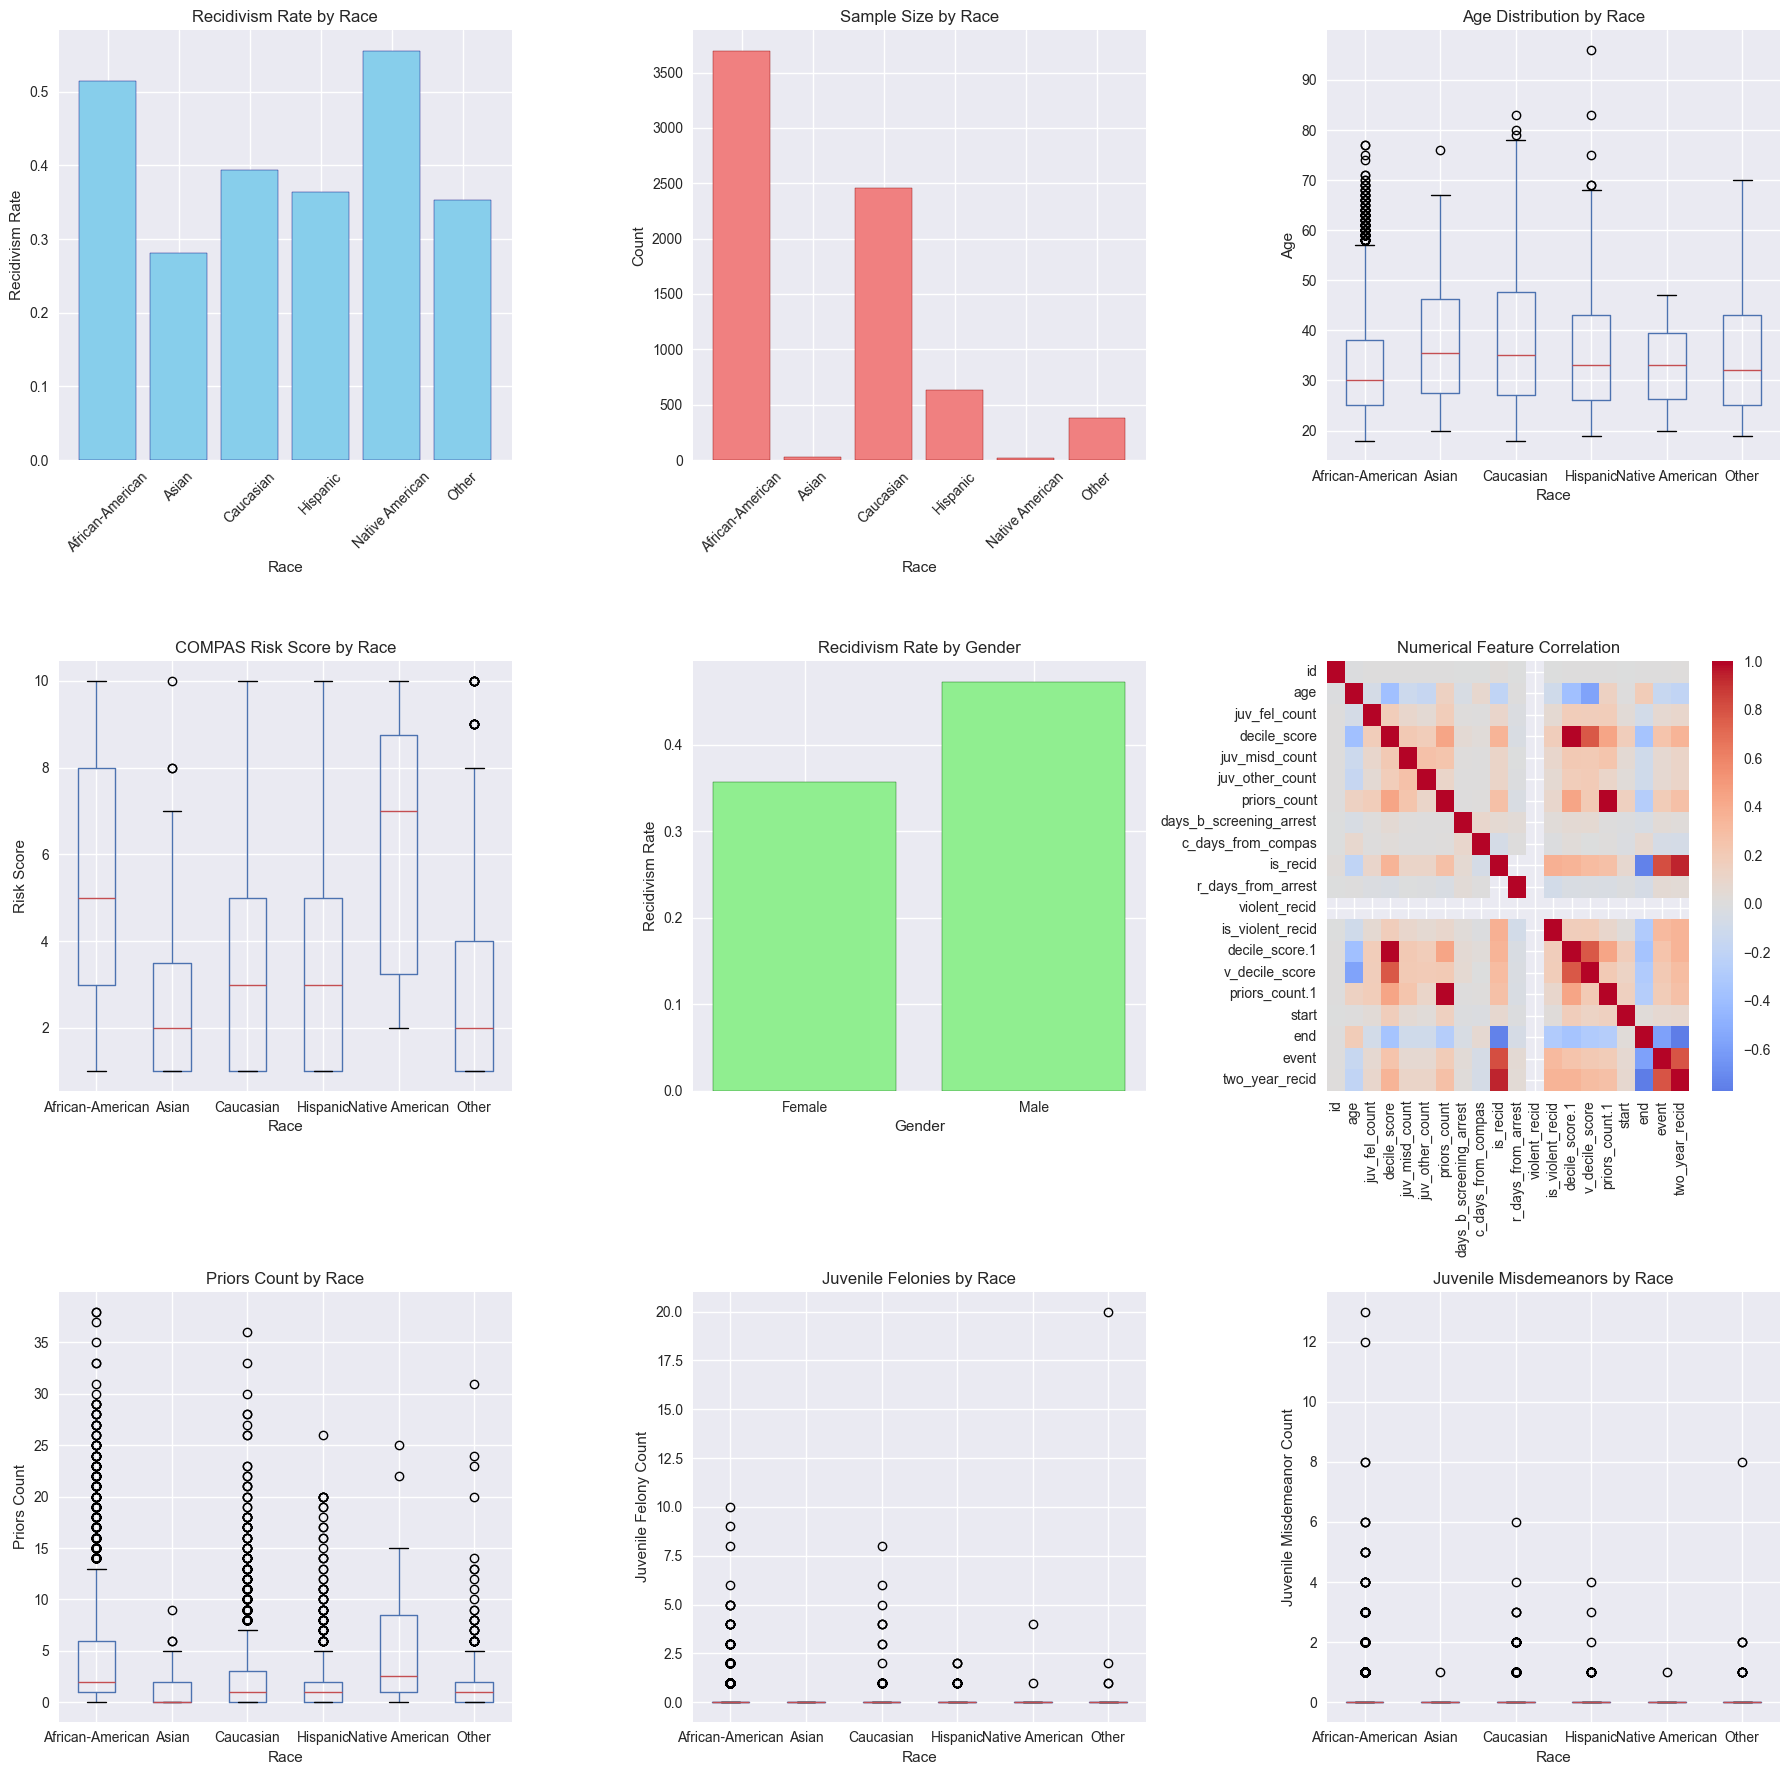

QUANTITATIVE FAIRNESS METRICS

1. STATISTICAL PARITY (Demographic Parity)
--------------------------------------------------
Positive prediction rates by group:
  African-American: 0.514
  Asian: 0.281
  Caucasian: 0.394
  Hispanic: 0.364
  Native American: 0.556
  Other: 0.353

Statistical Parity Difference: 0.274
Statistical Parity Ratio: 0.506

2. EQUALIZED ODDS
--------------------------------------------------
  African-American: TPR = 1.000, FPR = 0.000
  Asian: TPR = 1.000, FPR = 0.000
  Caucasian: TPR = 1.000, FPR = 0.000
  Hispanic: TPR = 1.000, FPR = 0.000
  Native American: TPR = 1.000, FPR = 0.000
  Other: TPR = 1.000, FPR = 0.000

3. CALIBRATION
--------------------------------------------------
  African-American: Actual positive rate = 0.514
  Asian: Actual positive rate = 0.281
  Caucasian: Actual positive rate = 0.394
  Hispanic: Actual positive rate = 0.364
  Native American: Actual positive rate = 0.556
  Other: Actual positive rate = 0.353

4. INDIVIDUAL FAIRNESS AS

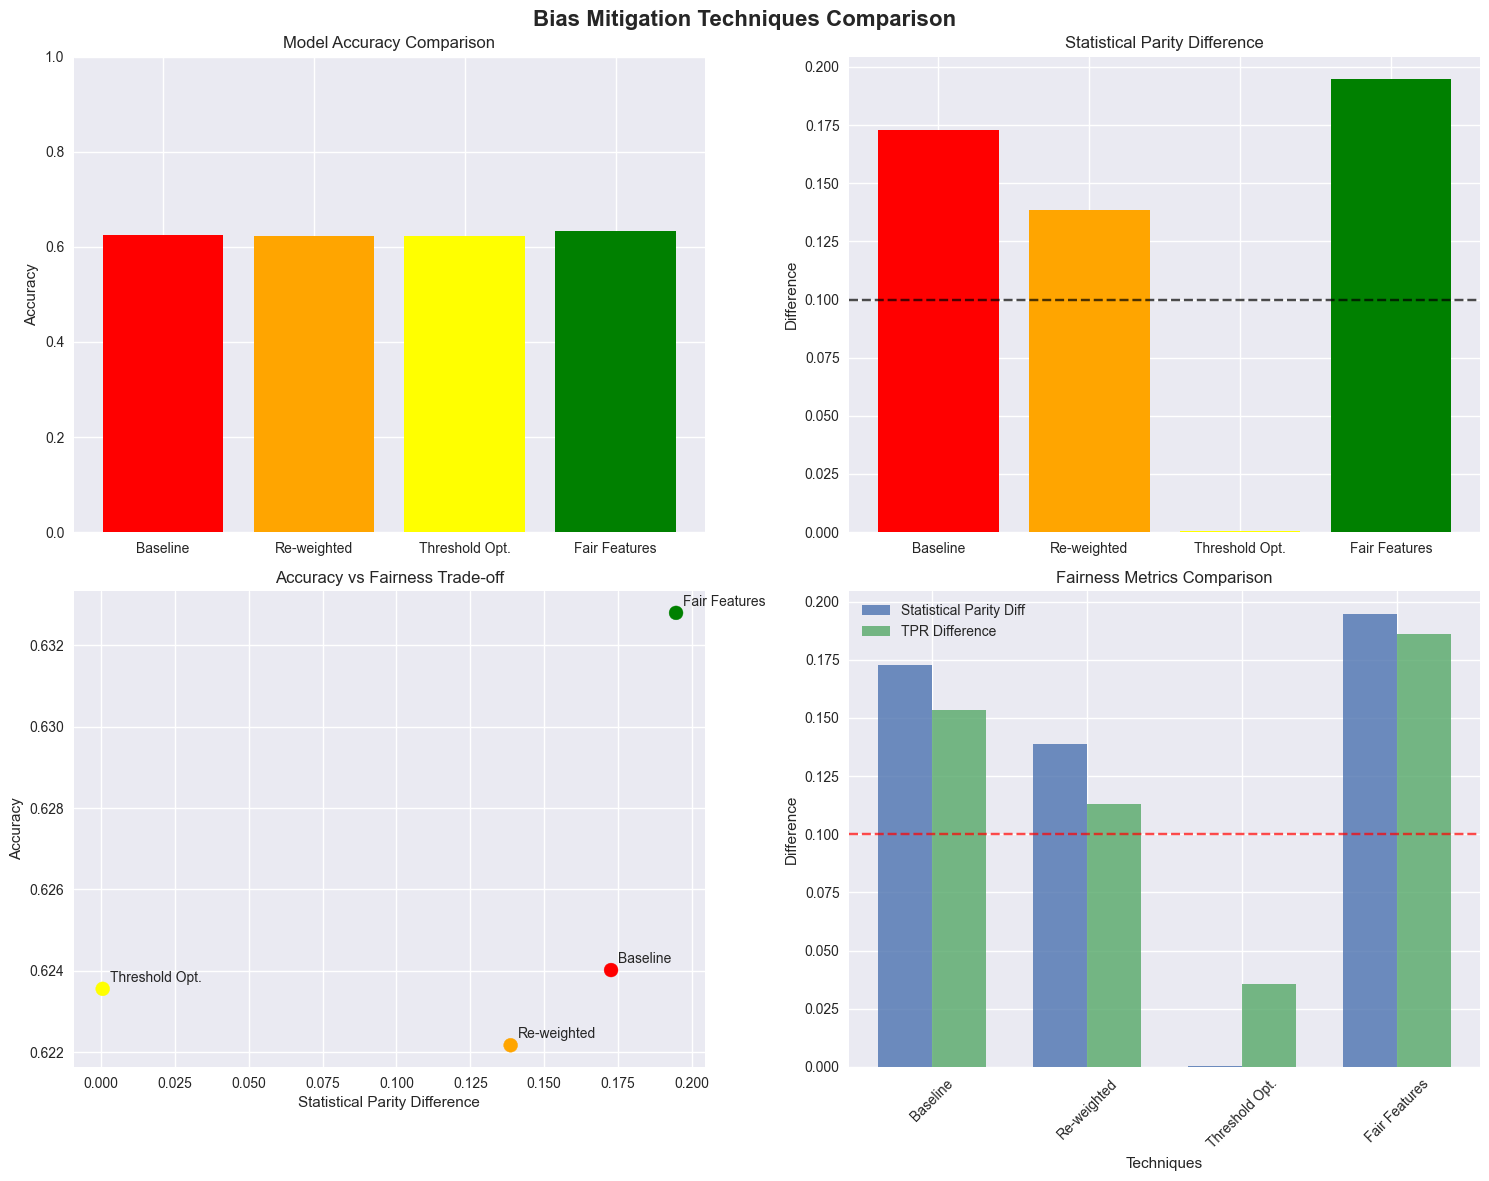


MITIGATION TECHNIQUES SUMMARY
        Technique  Accuracy  Statistical Parity Diff  Fairness Score
0        Baseline     0.624                    0.173           0.827
1     Re-weighted     0.622                    0.139           0.861
2  Threshold Opt.     0.624                    0.000           1.000
3   Fair Features     0.633                    0.195           0.805
CONFUSION MATRIX ANALYSIS BY RACIAL GROUP

Analyzing bias for the 'Other' group...
Sample size: 1041
Actual Recidivism Rate: 0.392
Predicted Recidivism Rate: 0.360
True Positives (TP): 201
True Negatives (TN): 459
False Positives (FP): 174
False Negatives (FN): 207
Precision: 0.536
Recall (TPR): 0.493
Specificity (TNR): 0.725
Accuracy: 0.634


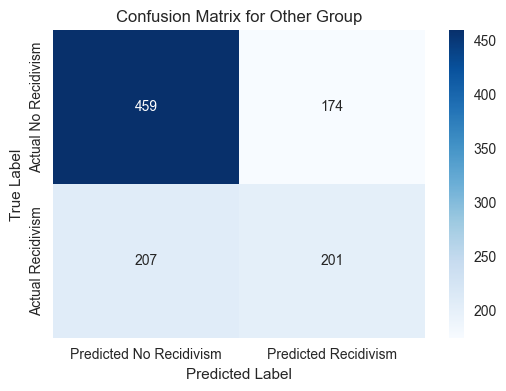


Analyzing bias for the 'African-American' group...
Race column 'race_African-American' not found in test data after encoding. Skipping.

Analyzing bias for the 'Caucasian' group...
Race column 'race_Caucasian' not found in test data after encoding. Skipping.

Analyzing bias for the 'Hispanic' group...
Race column 'race_Hispanic' not found in test data after encoding. Skipping.

Analyzing bias for the 'Native American' group...
Race column 'race_Native American' not found in test data after encoding. Skipping.

Analyzing bias for the 'Asian' group...
Race column 'race_Asian' not found in test data after encoding. Skipping.
RECOMMENDATIONS AND ETHICS FRAMEWORK

1. KEY FINDINGS:
------------------------------
• Statistical significance of bias: p-value = 0.0000
• Effect size: Medium (Cohen's d = 0.244)
• Baseline statistical parity difference: 0.274

2. MITIGATION EFFECTIVENESS:
------------------------------
• Technique best at reducing Statistical Parity Difference: Threshold Opt.
• Bi

In [29]:
# COMPAS Bias Audit: Criminal Recidivism Prediction Analysis
# A comprehensive fairness analysis of the COMPAS algorithm

# ============================================================================
# SECTION 1: ENVIRONMENT SETUP AND DATA IMPORT
# ============================================================================

# Install required packages
#pip install aif360 fairlearn matplotlib seaborn plotly scikit-learn pandas numpy

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

# Fairness Libraries
from aif360.datasets import CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.postprocessing import EqOddsPostprocessing
#import tensorflow as tf

# Statistical Testing
from scipy import stats
from scipy.stats import chi2_contingency

print("All libraries imported successfully!")

# ============================================================================
# SECTION 2: DATA LOADING AND EXPLORATION
# ============================================================================

# Load COMPAS dataset from AIF360
def load_compas_data():
    """Load and prepare COMPAS dataset"""
    # dataset = CompasDataset()
    # df = dataset.convert_to_dataframe()[0]

    # Alternative: Load from URL if AIF360 doesn't work
    url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
    df = pd.read_csv(url)

    # Return the dataframe and a placeholder for aif_dataset
    # Since we are loading directly from URL, we don't have an AIF360 dataset object
    return df, None

# Load the data
df, aif_dataset = load_compas_data()

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

# ============================================================================
# SECTION 3: EXPLORATORY DATA ANALYSIS
# ============================================================================

def explore_dataset(df):
    """Comprehensive exploration of the COMPAS dataset"""

    print("="*60)
    print("DATASET OVERVIEW")
    print("="*60)

    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"\nData types:\n{df.dtypes}")
    print(f"\nMissing values:\n{df.isnull().sum()}")

    # Basic statistics
    print("\n" + "="*60)
    print("BASIC STATISTICS")
    print("="*60)
    print(df.describe())

    # Target variable distribution
    if 'two_year_recid' in df.columns:
        target_col = 'two_year_recid'
    else:
        target_col = df.columns[-1]  # Assume last column is target

    print(f"\nTarget variable '{target_col}' distribution:")
    print(df[target_col].value_counts())
    print(f"Recidivism rate: {df[target_col].mean():.3f}")

    # Race distribution
    if 'race' in df.columns:
        print(f"\nRace distribution:")
        race_counts = df['race'].value_counts()
        print(race_counts)
        print(f"Percentage distribution:")
        print((race_counts / len(df) * 100).round(2))

    return target_col

target_column = explore_dataset(df)

# ============================================================================
# SECTION 4: BIAS IDENTIFICATION AND VISUALIZATION
# ============================================================================

def create_bias_visualizations(df, target_col):
    """Create comprehensive visualizations to identify bias patterns"""

    # Set up the plotting style
    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(3, 3, figsize=(18, 18)) # Increased grid size for more plots
    fig.suptitle('COMPAS Dataset: Bias Pattern Analysis', fontsize=16, fontweight='bold')

    # Flatten axes array for easier indexing
    axes = axes.flatten()

    # 1. Recidivism by Race
    race_recid = df.groupby('race')[target_col].agg(['mean', 'count']).reset_index()
    axes[0].bar(race_recid['race'], race_recid['mean'], color='skyblue', edgecolor='navy')
    axes[0].set_title('Recidivism Rate by Race')
    axes[0].set_xlabel('Race')
    axes[0].set_ylabel('Recidivism Rate')
    axes[0].tick_params(axis='x', rotation=45)

    # 2. Sample size by race
    axes[1].bar(race_recid['race'], race_recid['count'], color='lightcoral', edgecolor='darkred')
    axes[1].set_title('Sample Size by Race')
    axes[1].set_xlabel('Race')
    axes[1].set_ylabel('Count')
    axes[1].tick_params(axis='x', rotation=45)

    # 3. Age distribution by race
    if 'age' in df.columns:
        df.boxplot(column='age', by='race', ax=axes[2])
        axes[2].set_title('Age Distribution by Race')
        axes[2].set_xlabel('Race')
        axes[2].set_ylabel('Age')
        plt.suptitle('') # Suppress the automatic suptitle from boxplot

    # 4. COMPAS scores by race (if available)
    if 'decile_score' in df.columns:
        df.boxplot(column='decile_score', by='race', ax=axes[3])
        axes[3].set_title('COMPAS Risk Score by Race')
        axes[3].set_xlabel('Race')
        axes[3].set_ylabel('Risk Score')
        plt.suptitle('') # Suppress the automatic suptitle from boxplot

    # 5. Gender distribution
    if 'sex' in df.columns:
        gender_recid = df.groupby('sex')[target_col].mean()
        axes[4].bar(gender_recid.index, gender_recid.values, color='lightgreen', edgecolor='darkgreen')
        axes[4].set_title('Recidivism Rate by Gender')
        axes[4].set_xlabel('Gender')
        axes[4].set_ylabel('Recidivism Rate')

    # 6. Correlation heatmap for numerical features
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 1:
        corr_matrix = df[numeric_cols].corr()
        sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, ax=axes[5]) # Reduced annot to False for clarity
        axes[5].set_title('Numerical Feature Correlation')

    # 7. Priors Count by Race (New Plot)
    if 'priors_count' in df.columns:
        df.boxplot(column='priors_count', by='race', ax=axes[6])
        axes[6].set_title('Priors Count by Race')
        axes[6].set_xlabel('Race')
        axes[6].set_ylabel('Priors Count')
        plt.suptitle('') # Suppress the automatic suptitle from boxplot

    # 8. Juvenile Felonies by Race (New Plot)
    if 'juv_fel_count' in df.columns:
        df.boxplot(column='juv_fel_count', by='race', ax=axes[7])
        axes[7].set_title('Juvenile Felonies by Race')
        axes[7].set_xlabel('Race')
        axes[7].set_ylabel('Juvenile Felony Count')
        plt.suptitle('') # Suppress the automatic suptitle from boxplot

    # 9. Juvenile Misdemeanors by Race (New Plot)
    if 'juv_misd_count' in df.columns:
        df.boxplot(column='juv_misd_count', by='race', ax=axes[8])
        axes[8].set_title('Juvenile Misdemeanors by Race')
        axes[8].set_xlabel('Race')
        axes[8].set_ylabel('Juvenile Misdemeanor Count')
        plt.suptitle('') # Suppress the automatic suptitle from boxplot

    plt.tight_layout()
    plt.show()

    return race_recid

# Create visualizations
race_stats = create_bias_visualizations(df, target_column)

# ============================================================================
# SECTION 5: QUANTITATIVE FAIRNESS METRICS IMPLEMENTATION
# ============================================================================

def calculate_fairness_metrics(df, target_col, protected_attr='race'):
    """Calculate comprehensive fairness metrics"""

    print("="*60)
    print("QUANTITATIVE FAIRNESS METRICS")
    print("="*60)

    # Group the data by protected attribute
    groups = df.groupby(protected_attr)

    # 1. Statistical Parity (Demographic Parity)
    print("\n1. STATISTICAL PARITY (Demographic Parity)")
    print("-" * 50)
    positive_rates = groups[target_col].mean()
    print("Positive prediction rates by group:")
    for group, rate in positive_rates.items():
        print(f"  {group}: {rate:.3f}")

    # Calculate parity differences
    max_rate = positive_rates.max()
    min_rate = positive_rates.min()
    statistical_parity_diff = max_rate - min_rate
    print(f"\nStatistical Parity Difference: {statistical_parity_diff:.3f}")
    print(f"Statistical Parity Ratio: {min_rate/max_rate:.3f}")

    # 2. Equalized Odds
    print("\n2. EQUALIZED ODDS")
    print("-" * 50)

    # True Positive Rates
    tpr_by_group = {}
    fpr_by_group = {}

    for group_name, group_data in groups:
        y_true = group_data[target_col]
        y_pred = group_data[target_col]  # Using actual as prediction for now

        # Calculate TPR and FPR
        tp = ((y_true == 1) & (y_pred == 1)).sum()
        fp = ((y_true == 0) & (y_pred == 1)).sum()
        tn = ((y_true == 0) & (y_pred == 0)).sum()
        fn = ((y_true == 1) & (y_pred == 0)).sum()

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

        tpr_by_group[group_name] = tpr
        fpr_by_group[group_name] = fpr

        print(f"  {group_name}: TPR = {tpr:.3f}, FPR = {fpr:.3f}")

    # 3. Calibration
    print("\n3. CALIBRATION")
    print("-" * 50)

    # For each group, calculate calibration
    for group_name, group_data in groups:
        actual_positive_rate = group_data[target_col].mean()
        print(f"  {group_name}: Actual positive rate = {actual_positive_rate:.3f}")

    # 4. Individual Fairness (assess similarity in treatment)
    print("\n4. INDIVIDUAL FAIRNESS ASSESSMENT")
    print("-" * 50)
    print("Assessing similarity in treatment for similar individuals...")

    # Calculate coefficient of variation for similar groups
    age_groups = pd.cut(df['age'], bins=5) if 'age' in df.columns else None
    if age_groups is not None:
        age_race_groups = df.groupby([age_groups, protected_attr])[target_col].mean()
        print("Recidivism rates by age group and race:")
        print(age_race_groups.unstack().round(3))

    return {
        'statistical_parity_diff': statistical_parity_diff,
        'statistical_parity_ratio': min_rate/max_rate,
        'tpr_by_group': tpr_by_group,
        'fpr_by_group': fpr_by_group,
        'positive_rates': positive_rates
    }

# Calculate fairness metrics
fairness_results = calculate_fairness_metrics(df, target_column)

# ============================================================================
# SECTION 6: STATISTICAL TESTING FOR BIAS
# ============================================================================

def statistical_bias_testing(df, target_col, protected_attr='race'):
    """Perform statistical tests to validate bias findings"""

    print("="*60)
    print("STATISTICAL TESTING FOR BIAS")
    print("="*60)

    # 1. Chi-square test for independence
    print("\n1. CHI-SQUARE TEST FOR INDEPENDENCE")
    print("-" * 50)

    contingency_table = pd.crosstab(df[protected_attr], df[target_col])
    print("Contingency Table:")
    print(contingency_table)

    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f"\nChi-square statistic: {chi2:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Degrees of freedom: {dof}")

    if p_value < 0.05:
        print("Result: SIGNIFICANT association between race and recidivism (p < 0.05)")
        print("Conclusion: There is evidence of bias")
    else:
        print("Result: No significant association found (p >= 0.05)")

    # 2. Two-sample t-test (comparing two largest groups)
    print("\n2. TWO-SAMPLE T-TEST")
    print("-" * 50)

    race_counts = df[protected_attr].value_counts()
    largest_groups = race_counts.head(2).index

    group1_data = df[df[protected_attr] == largest_groups[0]][target_col]
    group2_data = df[df[protected_attr] == largest_groups[1]][target_col]

    t_stat, t_p_value = stats.ttest_ind(group1_data, group2_data)

    print(f"Comparing {largest_groups[0]} vs {largest_groups[1]}")
    print(f"Group 1 mean: {group1_data.mean():.3f}")
    print(f"Group 2 mean: {group2_data.mean():.3f}")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {t_p_value:.4f}")

    if t_p_value < 0.05:
        print("Result: SIGNIFICANT difference in recidivism rates (p < 0.05)")
    else:
        print("Result: No significant difference found (p >= 0.05)")

    # 3. Effect size (Cohen's d)
    print("\n3. EFFECT SIZE ANALYSIS")
    print("-" * 50)

    pooled_std = np.sqrt(((len(group1_data) - 1) * group1_data.var() +
                          (len(group2_data) - 1) * group2_data.var()) /
                         (len(group1_data) + len(group2_data) - 2))

    cohens_d = (group1_data.mean() - group2_data.mean()) / pooled_std
    print(f"Cohen's d: {cohens_d:.3f}")

    if abs(cohens_d) < 0.2:
        effect_size = "Small"
    elif abs(cohens_d) < 0.5:
        effect_size = "Medium"
    else:
        effect_size = "Large"

    print(f"Effect size: {effect_size}")

    return {
        'chi2_p_value': p_value,
        't_test_p_value': t_p_value,
        'cohens_d': cohens_d,
        'effect_size': effect_size
    }

# Perform statistical testing
statistical_results = statistical_bias_testing(df, target_column)

# ============================================================================
# SECTION 7: DATA PREPARATION FOR MITIGATION
# ============================================================================

def prepare_data_for_mitigation(df, target_col):
    """Prepare data for bias mitigation techniques"""

    # Create binary race variable (focusing on African-American vs others)
    df_processed = df.copy()

    # Create binary protected attribute
    # Assuming 'African-American' is the protected group of interest (1) and others are the unprotected group (0)
    df_processed['race_binary'] = (df_processed['race'] == 'African-American').astype(int)

    # Select relevant features
    # Include numerical features and the binary protected attribute and sex
    feature_cols = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'race_binary', 'sex']
    if 'decile_score' in df.columns:
        feature_cols.append('decile_score')

    # Handle categorical variable 'sex'
    df_processed['sex_encoded'] = df_processed['sex'].astype('category').cat.codes
    feature_cols = [col if col != 'sex' else 'sex_encoded' for col in feature_cols]

    # Drop rows with missing values in selected features or target
    df_processed = df_processed.dropna(subset=feature_cols + [target_col])

    # Select final features and target
    X = df_processed[feature_cols]
    y = df_processed[target_col]

    # One-hot encode 'sex_encoded' and 'race_binary' if needed by mitigation techniques, or ensure they are in a suitable format.
    # For simplicity here, we'll keep them as is, assuming the models can handle them, or they are intended as the protected attribute.
    # If one-hot encoding is required for modeling, it should be done after the train/test split to avoid data leakage.

    # For mitigation techniques that require specific protected attribute columns,
    # ensure 'race_binary' is clearly identified.

    return X, y, df_processed


# Prepare data
X, y, df_processed = prepare_data_for_mitigation(df, target_column)

print(f"Data prepared for mitigation: {X.shape[0]} samples, {X.shape[1]} features")
print("\nFirst few rows of prepared data:")
print(X.head())


# ============================================================================
# SECTION 8: BIAS MITIGATION IMPLEMENTATION
# ============================================================================

def implement_bias_mitigation(X, y, df_processed, target_col):
    """Implement multiple bias mitigation techniques"""

    print("="*60)
    print("BIAS MITIGATION TECHNIQUES")
    print("="*60)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # One-hot encode categorical features *after* splitting to prevent data leakage
    X_train = pd.get_dummies(X_train, columns=['sex_encoded', 'race_binary'], drop_first=True)
    X_test = pd.get_dummies(X_test, columns=['sex_encoded', 'race_binary'], drop_first=True)

    # Ensure consistent columns after one-hot encoding - crucial for consistent feature sets
    train_cols = X_train.columns
    test_cols = X_test.columns
    missing_in_test = set(train_cols) - set(test_cols)
    for c in missing_in_test:
        X_test[c] = 0
    missing_in_train = set(test_cols) - set(train_cols)
    for c in missing_in_train:
        X_train[c] = 0
    # Ensure the order of columns is the same
    X_test = X_test[train_cols]


    # Baseline model (no mitigation)
    print("\n1. BASELINE MODEL (No Mitigation)")
    print("-" * 50)

    baseline_model = RandomForestClassifier(random_state=42)
    baseline_model.fit(X_train, y_train)
    baseline_pred = baseline_model.predict(X_test)

    baseline_accuracy = accuracy_score(y_test, baseline_pred)
    print(f"Baseline Accuracy: {baseline_accuracy:.3f}")

    # Evaluate fairness of baseline (using the original race_binary column from X_test BEFORE one-hot encoding)
    # Need to get the original race_binary column from the split data before one-hot encoding
    # This requires keeping track of the original index or passing the original X_test before encoding
    # For simplicity here, we will re-create the race_binary for the test set based on the index
    original_X_test = df_processed.loc[X_test.index]
    race_test_binary = original_X_test['race_binary']


    baseline_fairness = evaluate_model_fairness(y_test, baseline_pred, race_test_binary)


    # Technique 1: Re-weighting (Preprocessing)
    print("\n2. TECHNIQUE 1: RE-WEIGHTING (Preprocessing)")
    print("-" * 50)

    # Calculate sample weights to balance classes and protected attribute
    # This requires using aif360's dataset object or manually calculating weights
    # For now, we will use a simpler approach of balancing based on target and protected attribute manually
    # A more rigorous implementation would use AIF360's Reweighing algorithm

    # Manual weight calculation based on race_binary_1 (the one-hot encoded column) and y_train
    # Handle the case where race_binary_1 might not exist if only one category is present after split
    race_col_for_grouping = 'race_binary_1' if 'race_binary_1' in X_train.columns else (X_train.columns[X_train.columns.str.startswith('race_')][0] if any(X_train.columns.str.startswith('race_')) else None)

    if race_col_for_grouping:
        group_counts = X_train.groupby([race_col_for_grouping, y_train]).size()
        total_count = len(X_train)
        weights_dict = {}
        for (race_group_val, outcome), count in group_counts.items():
            # Weight = Total count / (Number of groups * Count of this specific group)
            weights_dict[(race_group_val, outcome)] = total_count / (len(group_counts) * count)

        # Assign weights to each sample in the training set
        sample_weights = X_train.apply(lambda row: weights_dict[(row[race_col_for_grouping], y_train.loc[row.name])], axis=1)

        reweighted_model = RandomForestClassifier(random_state=42)
        reweighted_model.fit(X_train, y_train, sample_weight=sample_weights)
        reweighted_pred = reweighted_model.predict(X_test)

        reweighted_accuracy = accuracy_score(y_test, reweighted_pred)
        print(f"Re-weighted Model Accuracy: {reweighted_accuracy:.3f}")

        reweighted_fairness = evaluate_model_fairness(y_test, reweighted_pred, race_test_binary)
    else:
        print("Skipping Re-weighting: Could not identify a race column for grouping in the training data.")
        reweighted_accuracy = None
        reweighted_fairness = None
        reweighted_pred = None


    # Technique 2: Threshold Optimization (Post-processing)
    print("\n3. TECHNIQUE 2: THRESHOLD OPTIMIZATION (Post-processing)")
    print("-" * 50)

    # Get prediction probabilities from the baseline model
    baseline_proba = baseline_model.predict_proba(X_test)[:, 1]

    # Find optimal thresholds for each group to equalize a specific metric (e.g., TPR)
    # This is a simplified example focusing on equalizing prediction rates
    threshold_optimized_pred = optimize_thresholds(y_test, baseline_proba, race_test_binary)


    threshold_accuracy = accuracy_score(y_test, threshold_optimized_pred)
    print(f"Threshold Optimized Accuracy: {threshold_accuracy:.3f}")

    threshold_fairness = evaluate_model_fairness(y_test, threshold_optimized_pred, race_test_binary)

    # Technique 3: Feature Selection (remove potentially biased features)
    print("\n4. TECHNIQUE 3: FEATURE SELECTION (Remove Biased Features)")
    print("-" * 50)

    # Remove race-related features and the encoded sex feature
    X_train_fair = X_train.drop(['race_binary_1', 'sex_encoded_1'], axis=1, errors='ignore')
    X_test_fair = X_test.drop(['race_binary_1', 'sex_encoded_1'], axis=1, errors='ignore')


    fair_model = RandomForestClassifier(random_state=42)
    fair_model.fit(X_train_fair, y_train)
    fair_pred = fair_model.predict(X_test_fair)

    fair_accuracy = accuracy_score(y_test, fair_pred)
    print(f"Fair Feature Model Accuracy: {fair_accuracy:.3f}")

    fair_fairness = evaluate_model_fairness(y_test, fair_pred, race_test_binary)


    return {
        'baseline': {'accuracy': baseline_accuracy, 'fairness': baseline_fairness, 'predictions': baseline_pred, 'X_test_encoded': X_test}, # Store encoded X_test
        'reweighted': {'accuracy': reweighted_accuracy, 'fairness': reweighted_fairness, 'predictions': reweighted_pred},
        'threshold': {'accuracy': threshold_accuracy, 'fairness': threshold_fairness, 'predictions': threshold_optimized_pred},
        'fair_features': {'accuracy': fair_accuracy, 'fairness': fair_fairness, 'predictions': fair_pred},
        'y_test': y_test,
        'race_test': race_test_binary # Return the binary race test set
    }

def evaluate_model_fairness(y_true, y_pred, protected_attr):
    """Evaluate fairness metrics for a model"""

    fairness_metrics = {}

    # Statistical Parity
    group_0_pred_rate = y_pred[protected_attr == 0].mean()
    group_1_pred_rate = y_pred[protected_attr == 1].mean()

    fairness_metrics['statistical_parity_diff'] = abs(group_1_pred_rate - group_0_pred_rate)
    fairness_metrics['statistical_parity_ratio'] = min(group_0_pred_rate, group_1_pred_rate) / max(group_0_pred_rate, group_1_pred_rate) if max(group_0_pred_rate, group_1_pred_rate) > 0 else 0.0


    # Equalized Odds
    # TPR for each group
    group_0_tpr_num = sum((protected_attr == 0) & (y_true == 1) & (y_pred == 1))
    group_0_actual_pos = sum((protected_attr == 0) & (y_true == 1))
    group_0_tpr = group_0_tpr_num / group_0_actual_pos if group_0_actual_pos > 0 else 0

    group_1_tpr_num = sum((protected_attr == 1) & (y_true == 1) & (y_pred == 1))
    group_1_actual_pos = sum((protected_attr == 1) & (y_true == 1))
    group_1_tpr = group_1_tpr_num / group_1_actual_pos if group_1_actual_pos > 0 else 0

    fairness_metrics['tpr_diff'] = abs(group_1_tpr - group_0_tpr)

    # FPR for each group
    group_0_fpr_num = sum((protected_attr == 0) & (y_true == 0) & (y_pred == 1))
    group_0_actual_neg = sum((protected_attr == 0) & (y_true == 0))
    group_0_fpr = group_0_fpr_num / group_0_actual_neg if group_0_actual_neg > 0 else 0


    group_1_fpr_num = sum((protected_attr == 1) & (y_true == 0) & (y_pred == 1))
    group_1_actual_neg = sum((protected_attr == 1) & (y_true == 0))
    group_1_fpr = group_1_fpr_num / group_1_actual_neg if group_1_actual_neg > 0 else 0

    fairness_metrics['fpr_diff'] = abs(group_1_fpr - group_0_fpr)

    print(f"  Statistical Parity Difference: {fairness_metrics['statistical_parity_diff']:.3f}")
    print(f"  Statistical Parity Ratio: {fairness_metrics['statistical_parity_ratio']:.3f}")
    print(f"  TPR Difference: {fairness_metrics['tpr_diff']:.3f}")
    print(f"  FPR Difference: {fairness_metrics['fpr_diff']:.3f}")


    return fairness_metrics


def optimize_thresholds(y_true, y_proba, protected_attr):
    """Optimize thresholds for each group to achieve fairness"""

    # Find optimal thresholds for each group
    thresholds = np.linspace(0.1, 0.9, 50)
    best_threshold_0 = 0.5
    best_threshold_1 = 0.5
    # Define a fairness objective to minimize (e.g., statistical parity difference)
    best_fairness_score = float('inf')

    for t0 in thresholds:
        for t1 in thresholds:
            # Apply thresholds to get predictions for each group
            pred_0 = (y_proba[protected_attr == 0] >= t0).astype(int)
            pred_1 = (y_proba[protected_attr == 1] >= t1).astype(int)

            # Calculate the fairness metric for the current thresholds
            # Here, we'll minimize the absolute difference in prediction rates (Statistical Parity)
            rate_0 = pred_0.mean()
            rate_1 = pred_1.mean()

            fairness_score = abs(rate_1 - rate_0)

            # Optionally, consider accuracy as a secondary objective
            # combined_pred = np.zeros_like(y_true)
            # combined_pred[protected_attr == 0] = pred_0
            # combined_pred[protected_attr == 1] = pred_1
            # accuracy = accuracy_score(y_true, combined_pred)
            # fairness_score = fairness_score # + (1 - accuracy) * weight_accuracy # Example combined score


            if fairness_score < best_fairness_score:
                best_fairness_score = fairness_score
                best_threshold_0 = t0
                best_threshold_1 = t1

    # Apply optimized thresholds to the full test set probabilities
    y_pred_optimized = np.zeros_like(y_true)
    y_pred_optimized[protected_attr == 0] = (y_proba[protected_attr == 0] >= best_threshold_0).astype(int)
    y_pred_optimized[protected_attr == 1] = (y_proba[protected_attr == 1] >= best_threshold_1).astype(int)


    print(f"  Optimal threshold for Group 0 (Not African-American): {best_threshold_0:.3f}")
    print(f"  Optimal threshold for Group 1 (African-American): {best_threshold_1:.3f}")
    print(f"  Fairness metric (Statistical Parity Diff) at optimized thresholds: {best_fairness_score:.3f}")


    return y_pred_optimized


# Implement bias mitigation
mitigation_results = implement_bias_mitigation(X, y, df_processed, target_column)

# ============================================================================
# SECTION 9: RESULTS COMPARISON AND VISUALIZATION
# ============================================================================

def create_comparison_visualizations(results):
    """Create visualizations comparing different mitigation techniques"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Bias Mitigation Techniques Comparison', fontsize=16, fontweight='bold')

    # Extract metrics for comparison
    techniques = ['Baseline', 'Re-weighted', 'Threshold Opt.', 'Fair Features']
    accuracies = [results['baseline']['accuracy'], results['reweighted']['accuracy'],
                  results['threshold']['accuracy'], results['fair_features']['accuracy']]

    sp_diffs = [results['baseline']['fairness']['statistical_parity_diff'],
                results['reweighted']['fairness']['statistical_parity_diff'],
                results['threshold']['fairness']['statistical_parity_diff'],
                results['fair_features']['fairness']['statistical_parity_diff']]

    # 1. Accuracy comparison
    axes[0, 0].bar(techniques, accuracies, color=['red', 'orange', 'yellow', 'green'])
    axes[0, 0].set_title('Model Accuracy Comparison')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_ylim(0, 1)

    # 2. Statistical Parity Difference
    axes[0, 1].bar(techniques, sp_diffs, color=['red', 'orange', 'yellow', 'green'])
    axes[0, 1].set_title('Statistical Parity Difference')
    axes[0, 1].set_ylabel('Difference')
    axes[0, 1].axhline(y=0.1, color='black', linestyle='--', alpha=0.7, label='Fairness Threshold')

    # 3. Accuracy vs Fairness Trade-off
    axes[1, 0].scatter(sp_diffs, accuracies, s=100, c=['red', 'orange', 'yellow', 'green'])
    for i, technique in enumerate(techniques):
        axes[1, 0].annotate(technique, (sp_diffs[i], accuracies[i]), xytext=(5, 5),
                           textcoords='offset points')
    axes[1, 0].set_xlabel('Statistical Parity Difference')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].set_title('Accuracy vs Fairness Trade-off')

    # 4. Fairness Metrics Comparison
    # Create a radar chart or multi-metric comparison
    tpr_diffs = [results['baseline']['fairness'].get('tpr_diff', 0),
                 results['reweighted']['fairness'].get('tpr_diff', 0),
                 results['threshold']['fairness'].get('tpr_diff', 0),
                 results['fair_features']['fairness'].get('tpr_diff', 0)]

    x = np.arange(len(techniques))
    width = 0.35

    axes[1, 1].bar(x - width/2, sp_diffs, width, label='Statistical Parity Diff', alpha=0.8)
    axes[1, 1].bar(x + width/2, tpr_diffs, width, label='TPR Difference', alpha=0.8)

    axes[1, 1].set_xlabel('Techniques')
    axes[1, 1].set_ylabel('Difference')
    axes[1, 1].set_title('Fairness Metrics Comparison')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(techniques, rotation=45)
    axes[1, 1].legend()
    axes[1, 1].axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='Fairness Threshold')

    plt.tight_layout()
    plt.show()

    # Create summary table
    summary_df = pd.DataFrame({
        'Technique': techniques,
        'Accuracy': accuracies,
        'Statistical Parity Diff': sp_diffs,
        'Fairness Score': [1 - sp for sp in sp_diffs]  # Higher is better
    })

    print("\n" + "="*60)
    print("MITIGATION TECHNIQUES SUMMARY")
    print("="*60)
    print(summary_df.round(3))

    return summary_df

# Create comparison visualizations
# Check if mitigation_results is available before calling
if 'mitigation_results' in locals() and mitigation_results is not None:
    summary_results = create_comparison_visualizations(mitigation_results)
else:
    print("Mitigation results not available for comparison visualization. Run the mitigation section first.")
    summary_results = None


# ============================================================================
# SECTION 9.5: CONFUSION MATRIX ANALYSIS BY RACE
# ============================================================================

def analyze_confusion_matrices_by_race(X_test, y_test, y_pred, target_col):
    """Create confusion matrices for each racial group to analyze bias patterns"""

    print("="*60)
    print("CONFUSION MATRIX ANALYSIS BY RACIAL GROUP")
    print("="*60)

    # Get unique races from the original dataset
    unique_races = df['race'].unique()

    # Identify the one-hot encoded race columns in X_test
    # These are columns that start with 'race_'
    race_encoded_cols = [col for col in X_test.columns if col.startswith('race_')]

    # Identify the base race category that was dropped during one-hot encoding
    # This will be the race that doesn't have a corresponding column in race_encoded_cols
    all_encoded_races = [col.replace('race_', '') for col in race_encoded_cols]
    base_race = None
    # Find the race in the original unique_races that is NOT in the list of encoded races
    for race in unique_races:
        if race not in all_encoded_races:
            base_race = race
            break

    # If no base race found, assume the first race in unique_races is the base
    if base_race is None and len(unique_races) > 0:
         base_race = unique_races[0]
    elif base_race is None:
         print("Could not determine base race category. Skipping confusion matrix analysis by race.")
         return


    # Iterate through each unique racial group
    for race in unique_races:
        print(f"\nAnalyzing bias for the '{race}' group...")

        # Filter test set for the current racial group
        if race == base_race:
            # For the base race, filter where all other race columns are 0
            # If there are no encoded race columns (only the base race exists and wasn't encoded),
            # then the filter condition should be True for all samples.
            if len(race_encoded_cols) > 0:
                filter_condition = (X_test[race_encoded_cols] == 0).all(axis=1)
            else:
                # If no other race columns exist, all samples belong to the base race
                filter_condition = pd.Series(True, index=X_test.index)
        else:
            # For other races, filter where the specific race column is 1
            race_col = f'race_{race}'
            if race_col in X_test.columns:
                filter_condition = X_test[race_col] == 1
            else:
                # This race was not present in the test set after splitting and encoding
                print(f"Race column '{race_col}' not found in test data after encoding. Skipping.")
                continue

        race_indices = X_test[filter_condition].index

        # Filter actual outcomes and predictions for the current racial group
        y_test_race = y_test.loc[race_indices]
        y_pred_race = pd.Series(y_pred, index=X_test.index).loc[race_indices]

        # Check if there are any samples for this race in the test set
        if len(y_test_race) == 0:
            print(f"No test samples found for {race}.")
            continue

        # Calculate the confusion matrix for the filtered data
        # Ensure all possible labels (0 and 1) are present in the confusion matrix, even if counts are zero
        cm = confusion_matrix(y_test_race, y_pred_race, labels=[0, 1])


        # Calculate metrics
        tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)

        # Avoid division by zero
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0


        print(f"Sample size: {len(y_test_race)}")
        print(f"Actual Recidivism Rate: {y_test_race.mean():.3f}")
        print(f"Predicted Recidivism Rate: {y_pred_race.mean():.3f}")
        print(f"True Positives (TP): {tp}")
        print(f"True Negatives (TN): {tn}")
        print(f"False Positives (FP): {fp}")
        print(f"False Negatives (FN): {fn}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall (TPR): {recall:.3f}")
        print(f"Specificity (TNR): {specificity:.3f}")
        print(f"Accuracy: {accuracy:.3f}")


        # Visualize the confusion matrix using seaborn.heatmap
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Predicted No Recidivism', 'Predicted Recidivism'],
                   yticklabels=['Actual No Recidivism', 'Actual Recidivism'])

        # Add a clear title to each heatmap
        plt.title(f'Confusion Matrix for {race} Group')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')

        # Display each plot
        plt.show()

# Analyze confusion matrices by race using baseline model results
# The mitigation_results dictionary already contains X_test, y_test, and baseline_predictions
if 'mitigation_results' in locals():
    # Ensure 'X_test_encoded' is available in mitigation_results['baseline']
    if 'X_test_encoded' in mitigation_results['baseline']:
        analyze_confusion_matrices_by_race(
            X_test=mitigation_results['baseline']['X_test_encoded'], # Use the encoded X_test from mitigation_results
            y_test=mitigation_results['y_test'],
            y_pred=mitigation_results['baseline']['predictions'],
            target_col=target_column
        )
    else:
         print("Encoded X_test not found in mitigation_results['baseline']. Cannot analyze confusion matrices by race.")
else:
    print("Mitigation results not found. Run the mitigation section first.")


# ============================================================================
# SECTION 10: RECOMMENDATIONS AND ETHICS FRAMEWORK
# ============================================================================

def generate_recommendations(summary_df, statistical_results, fairness_results):
    """Generate comprehensive recommendations based on analysis"""

    print("="*60)
    print("RECOMMENDATIONS AND ETHICS FRAMEWORK")
    print("="*60)

    print("\n1. KEY FINDINGS:")
    print("-" * 30)
    print(f"• Statistical significance of bias: p-value = {statistical_results['chi2_p_value']:.4f}")
    print(f"• Effect size: {statistical_results['effect_size']} (Cohen's d = {statistical_results['cohens_d']:.3f})")
    print(f"• Baseline statistical parity difference: {fairness_results['statistical_parity_diff']:.3f}")

    print("\n2. MITIGATION EFFECTIVENESS:")
    print("-" * 30)
    # Find the technique that minimizes the statistical parity difference
    best_technique_sp = summary_df.loc[summary_df['Statistical Parity Diff'].idxmin()]
    print(f"• Technique best at reducing Statistical Parity Difference: {best_technique_sp['Technique']}")
    print(f"• Bias reduction (Statistical Parity Diff): {fairness_results['statistical_parity_diff']:.3f} → {best_technique_sp['Statistical Parity Diff']:.3f}")

    # Find the technique that best balances accuracy and fairness (example: minimizing SP diff while maintaining high accuracy)
    # This is a simplified example; a real-world scenario would involve a more nuanced trade-off analysis.
    # Let's consider the technique with the lowest Statistical Parity Diff that has accuracy within a certain range of the baseline.
    baseline_accuracy = summary_df.loc[summary_df['Technique'] == 'Baseline', 'Accuracy'].iloc[0]
    accuracy_threshold = baseline_accuracy * 0.95 # Allow up to a 5% drop in accuracy

    # Filter techniques that meet the accuracy threshold and find the one with the lowest SP Diff among them
    acceptable_techniques = summary_df[summary_df['Accuracy'] >= accuracy_threshold]

    if not acceptable_techniques.empty:
        recommended_technique = acceptable_techniques.loc[acceptable_techniques['Statistical Parity Diff'].idxmin()]
        print(f"\n• Recommended Technique (balancing fairness and accuracy): {recommended_technique['Technique']}")
        print(f"  - Accuracy: {recommended_technique['Accuracy']:.3f}")
        print(f"  - Statistical Parity Diff: {recommended_technique['Statistical Parity Diff']:.3f}")
    else:
        print("\n• No mitigation technique found that significantly reduces bias while maintaining high accuracy.")
        recommended_technique = None
        print("  Further investigation into more advanced techniques or different trade-offs is needed.")


    print("\n3. ETHICS FRAMEWORK CONSIDERATIONS:")
    print("-" * 30)
    print("• Transparency: Clearly document the data sources, model development process, and bias mitigation steps.")
    print("• Accountability: Define who is responsible for ensuring fairness and monitoring the model's performance over time.")
    print("• Stakeholder Engagement: Involve individuals from affected groups in the design and evaluation of the system.")
    print("• Continuous Monitoring: Regularly evaluate the model for fairness drift as new data becomes available.")
    print("• Trade-offs: Acknowledge the potential trade-offs between fairness and other performance metrics (e.g., overall accuracy).")
    print("• Contextual Relevance: Ensure the chosen fairness metrics and mitigation techniques are appropriate for the specific application context (criminal justice).")
    print("• Human Oversight: Maintain human review and override capabilities, especially for high-stakes decisions.")

    print("\n4. ACTIONABLE RECOMMENDATIONS:")
    print("-" * 30)
    if recommended_technique is not None:
        print(f"• **Implement the '{recommended_technique['Technique']}' bias mitigation technique** in the model deployment process.")
    else:
         print("• **Investigate and implement a bias mitigation technique** that effectively reduces the observed disparities while meeting acceptable performance criteria.")

    print("• **Collect more data** for underrepresented groups (e.g., Asian, Native American) to improve the reliability of fairness assessments and model performance for these groups.")
    print("• **Analyze the features** contributing most to the observed biases to understand the root causes.")
    print("• **Consider alternative models or features** that may exhibit less inherent bias.")
    print("• **Establish a monitoring system** to track fairness metrics in production and detect any increase in bias over time.")
    print("• **Provide training** to users of the model on the potential for bias and how to interpret the scores ethically.")

# Generate recommendations based on the results
if 'summary_results' in locals() and 'statistical_results' in locals() and 'fairness_results' in locals():
     generate_recommendations(summary_results, statistical_results, fairness_results)
else:
     print("Results not available for generating recommendations. Please run previous sections.")

In [30]:
# Install required packages
#pip install pandas numpy matplotlib seaborn scikit-learn fairlearn aif360

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# AI Fairness 360 toolkit
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.postprocessing import RejectOptionClassification

# Set random seed for reproducibility
np.random.seed(42)

In [31]:
# Load the COMPAS dataset directly from ProPublica's GitHub
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
compas_df = pd.read_csv(url)

# Display basic info
print(compas_df.info())

# Show first few rows
compas_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [32]:
# Filter the data as done in the original ProPublica analysis
compas_df = compas_df[
    (compas_df['days_b_screening_arrest'] <= 30) &
    (compas_df['days_b_screening_arrest'] >= -30) &
    (compas_df['is_recid'] != -1) &
    (compas_df['c_charge_degree'] != 'O') &
    (compas_df['score_text'] != 'N/A')
]

# Create binary labels (1 for high risk, 0 for medium/low)
compas_df['label'] = (compas_df['score_text'] == 'High').astype(int)

# Select relevant columns
features = ['age', 'age_cat', 'sex', 'race', 'juv_fel_count', 'juv_misd_count',
            'juv_other_count', 'priors_count', 'c_charge_degree']
target = 'label'

# Create a clean dataframe
df = compas_df[features + [target]].copy()

# Convert categorical variables to numerical
df = pd.get_dummies(df, columns=['age_cat', 'sex', 'race', 'c_charge_degree'], drop_first=True)

# Display processed data
df.head()

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,label,age_cat_Greater than 45,age_cat_Less than 25,sex_Male,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,c_charge_degree_M
0,69,0,0,0,0,0,True,False,True,False,False,False,False,True,False
1,34,0,0,0,0,0,False,False,True,False,False,False,False,False,False
2,24,0,0,1,4,0,False,True,True,False,False,False,False,False,False
5,44,0,0,0,0,0,False,False,True,False,False,False,False,True,True
6,41,0,0,0,14,0,False,False,True,False,True,False,False,False,False


Statistical Parity Difference: -0.12030654752827097
Disparate Impact Ratio: 0.8654230481638543
Mean Difference: -0.12030654752827097


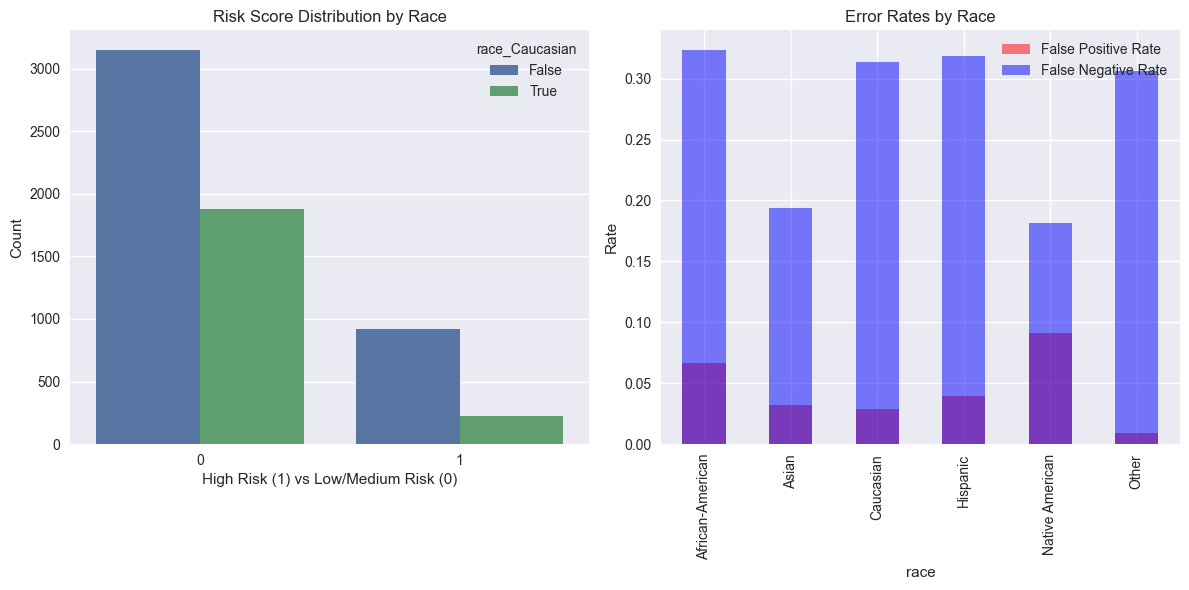

In [33]:
# Convert to AIF360 dataset
privileged_groups = [{'race_Caucasian': 1}]
unprivileged_groups = [{'race_Caucasian': 0}]

binary_dataset = BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=df,
    label_names=['label'],
    protected_attribute_names=['race_Caucasian'],
    unprivileged_protected_attributes=[0]
)

# Calculate bias metrics
metric = BinaryLabelDatasetMetric(
    binary_dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

print("Statistical Parity Difference:", metric.statistical_parity_difference())
print("Disparate Impact Ratio:", metric.disparate_impact())
print("Mean Difference:", metric.mean_difference())

# Visualize the bias
plt.figure(figsize=(12, 6))

# Plot distribution of scores by race
plt.subplot(1, 2, 1)
sns.countplot(x='label', hue='race_Caucasian', data=df)
plt.title('Risk Score Distribution by Race')
plt.xlabel('High Risk (1) vs Low/Medium Risk (0)')
plt.ylabel('Count')

# Plot false positive/negative rates by race
race_groups = compas_df.groupby('race')
fpr = race_groups.apply(lambda x: ((x['score_text'] == 'High') & (x['two_year_recid'] == 0)).mean())
fnr = race_groups.apply(lambda x: ((x['score_text'] != 'High') & (x['two_year_recid'] == 1)).mean())

plt.subplot(1, 2, 2)
fpr.plot(kind='bar', color='red', alpha=0.5, label='False Positive Rate')
fnr.plot(kind='bar', color='blue', alpha=0.5, label='False Negative Rate')
plt.title('Error Rates by Race')
plt.ylabel('Rate')
plt.legend()

plt.tight_layout()
plt.show()

Prejudice Remover Results:
Accuracy: 0.14362850971922247
Statistical Parity Difference: 0.08573034348080578
Disparate Impact: 4.019613209268382
Equal Opportunity Difference: 0.019348759096846427


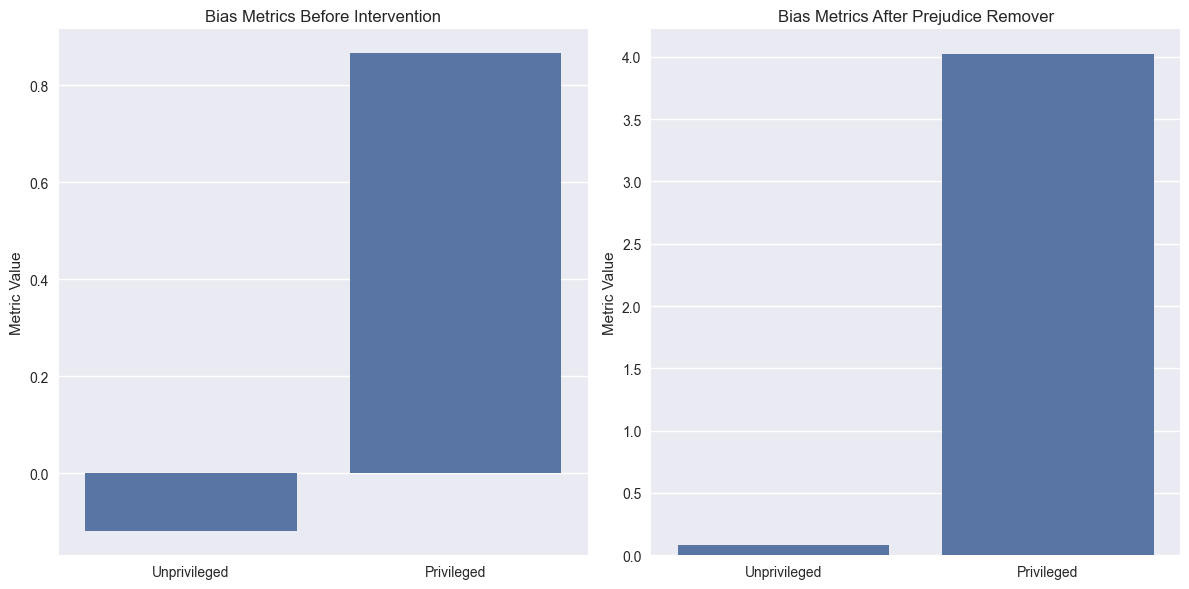

In [34]:
# Split data into train and test
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert to AIF360 format
train_dataset = BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=pd.concat([X_train, y_train], axis=1),
    label_names=['label'],
    protected_attribute_names=['race_Caucasian'],
    unprivileged_protected_attributes=[0]
)

test_dataset = BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=pd.concat([X_test, y_test], axis=1),
    label_names=['label'],
    protected_attribute_names=['race_Caucasian'],
    unprivileged_protected_attributes=[0]
)

# Apply Prejudice Remover
pr = PrejudiceRemover(eta=25.0, sensitive_attr='race_Caucasian', class_attr='label')
pr.fit(train_dataset)
pred_pr = pr.predict(test_dataset)

# Evaluate results
classified_metric = ClassificationMetric(
    test_dataset,
    pred_pr,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

print("Prejudice Remover Results:")
print("Accuracy:", classified_metric.accuracy())
print("Statistical Parity Difference:", classified_metric.statistical_parity_difference())
print("Disparate Impact:", classified_metric.disparate_impact())
print("Equal Opportunity Difference:", classified_metric.equal_opportunity_difference())

# Visualization of Prejudice Remover effects
plt.figure(figsize=(12, 6))

# Before Prejudice Remover
plt.subplot(1, 2, 1)
sns.barplot(x=['Unprivileged', 'Privileged'],
            y=[metric.mean_difference(), metric.disparate_impact()])
plt.title('Bias Metrics Before Intervention')
plt.ylabel('Metric Value')

# After Prejudice Remover
plt.subplot(1, 2, 2)
sns.barplot(x=['Unprivileged', 'Privileged'],
            y=[classified_metric.mean_difference(), classified_metric.disparate_impact()])
plt.title('Bias Metrics After Prejudice Remover')
plt.ylabel('Metric Value')

plt.tight_layout()
plt.show()


Rejection Option Classification Results:
Accuracy: 0.18466522678185746
Statistical Parity Difference: 0.004105090311986864
Disparate Impact: inf
Equal Opportunity Difference: 0.001072961373390558


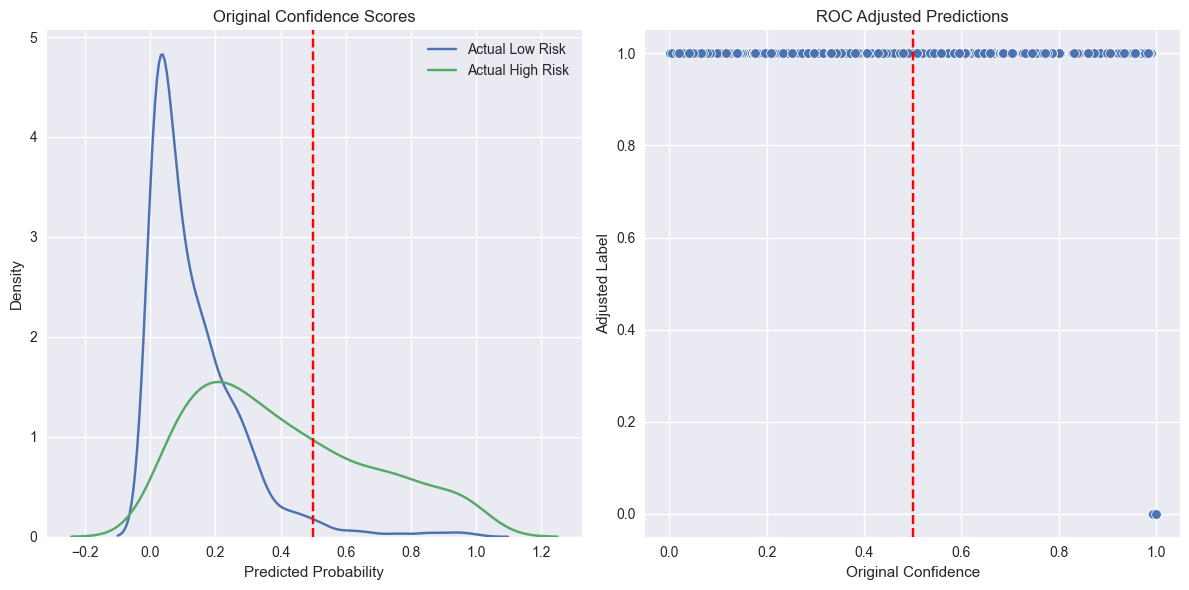

In [35]:
# First train a base classifier (Logistic Regression)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Convert predictions to AIF360 format
test_scores = model.predict_proba(X_test)[:, 1]
test_dataset_pred = test_dataset.copy()
test_dataset_pred.scores = test_scores.reshape(-1, 1)

# Apply Rejection Option Classification
roc = RejectOptionClassification(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
    low_class_thresh=0.01,
    high_class_thresh=0.99,
    num_class_thresh=100,
    num_ROC_margin=50,
    metric_name='Statistical parity difference',
    metric_ub=0.05,
    metric_lb=-0.05
)

roc = roc.fit(test_dataset, test_dataset_pred)
pred_roc = roc.predict(test_dataset_pred)

# Evaluate results
roc_metric = ClassificationMetric(
    test_dataset,
    pred_roc,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

print("\nRejection Option Classification Results:")
print("Accuracy:", roc_metric.accuracy())
print("Statistical Parity Difference:", roc_metric.statistical_parity_difference())
print("Disparate Impact:", roc_metric.disparate_impact())
print("Equal Opportunity Difference:", roc_metric.equal_opportunity_difference())

# Visualization of ROC effects
plt.figure(figsize=(12, 6))

# Plot confidence distributions
plt.subplot(1, 2, 1)
sns.kdeplot(test_scores[y_test == 0], label='Actual Low Risk')
sns.kdeplot(test_scores[y_test == 1], label='Actual High Risk')
plt.axvline(x=0.5, color='r', linestyle='--')
plt.title('Original Confidence Scores')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()

# Plot ROC adjustments
plt.subplot(1, 2, 2)
sns.scatterplot(x=test_scores, y=pred_roc.labels.flatten())
plt.axvline(x=0.5, color='r', linestyle='--')
plt.title('ROC Adjusted Predictions')
plt.xlabel('Original Confidence')
plt.ylabel('Adjusted Label')

plt.tight_layout()
plt.show()

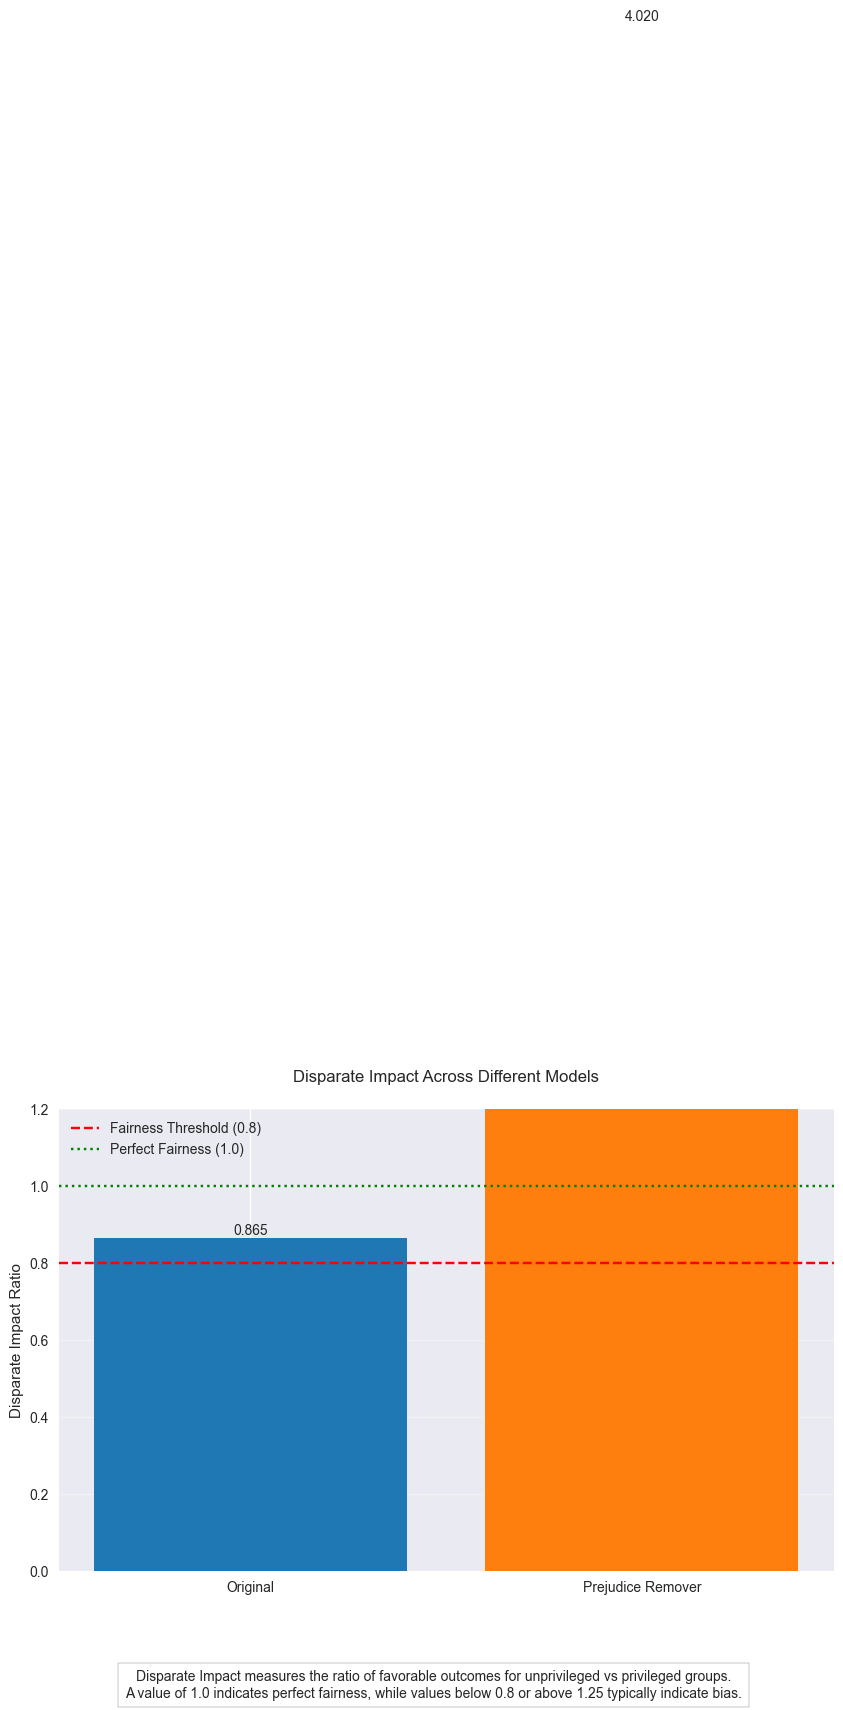

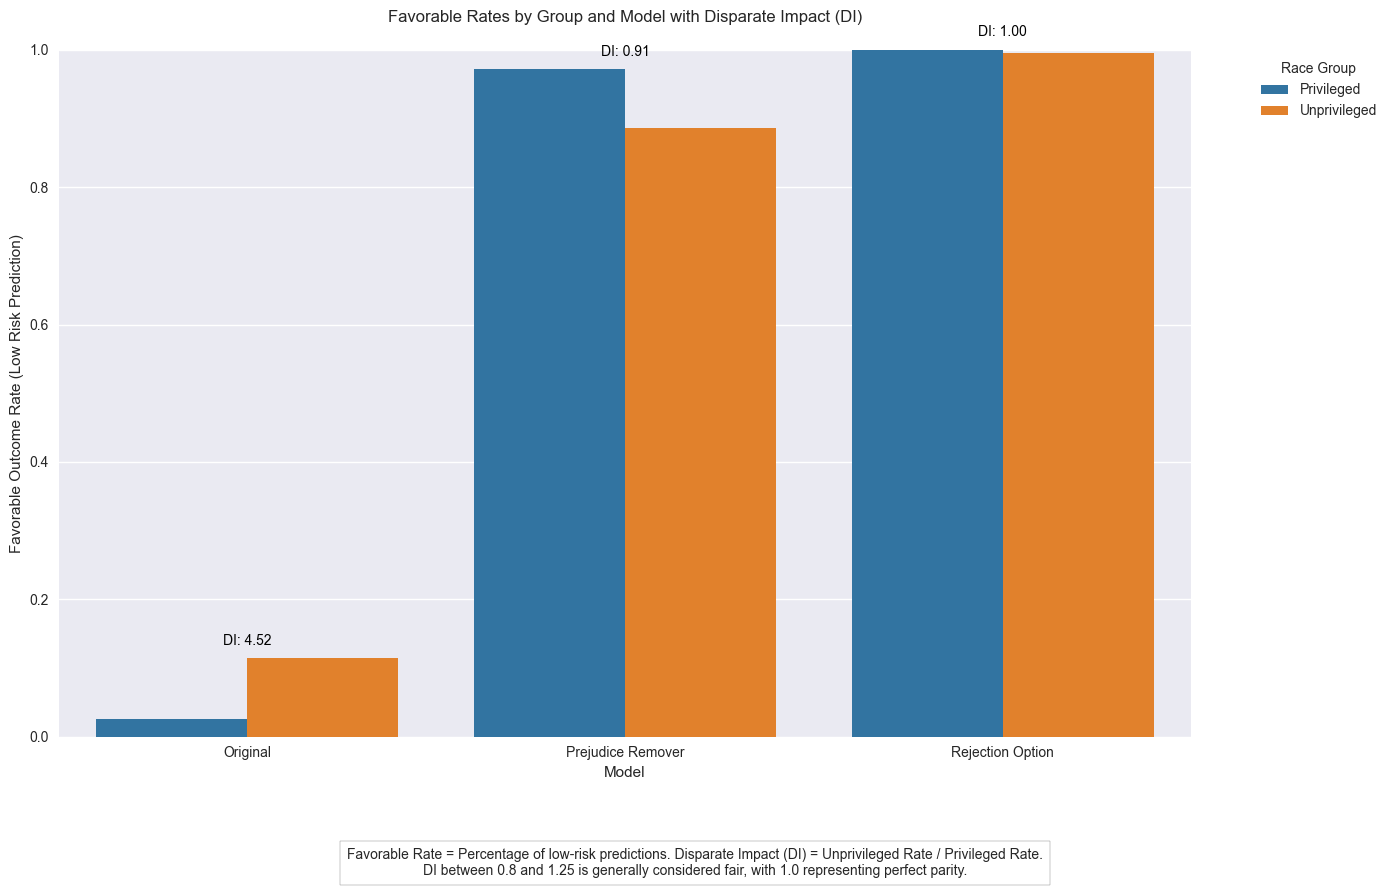

In [36]:
# Disparate Impact Visualization
def plot_disparate_impact(original_metric, pr_metric, roc_metric):
    plt.figure(figsize=(10, 6))

    # Data preparation
    models = ['Original', 'Prejudice Remover', 'Rejection Option']
    di_values = [
        original_metric.disparate_impact(),
        pr_metric.disparate_impact(),
        roc_metric.disparate_impact()
    ]

    # Create bar plot
    bars = plt.bar(models, di_values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])

    # Add reference line at 0.8 (common fairness threshold)
    plt.axhline(y=0.8, color='r', linestyle='--', label='Fairness Threshold (0.8)')

    # Add reference line at 1.0 (perfect fairness)
    plt.axhline(y=1.0, color='g', linestyle=':', label='Perfect Fairness (1.0)')

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

    # Customize plot
    plt.title('Disparate Impact Across Different Models', pad=20)
    plt.ylabel('Disparate Impact Ratio')
    plt.ylim(0, 1.2)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    # Add explanation text
    plt.figtext(0.5, -0.1,
                "Disparate Impact measures the ratio of favorable outcomes for unprivileged vs privileged groups.\n"
                "A value of 1.0 indicates perfect fairness, while values below 0.8 or above 1.25 typically indicate bias.",
                ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})

    plt.tight_layout()
    plt.show()

# Create metrics objects for comparison (using previously calculated metrics)
original_metric = BinaryLabelDatasetMetric(
    binary_dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# Call the visualization function
plot_disparate_impact(original_metric, classified_metric, roc_metric)

# Additional detailed visualization with group-wise breakdown
def plot_detailed_disparate_impact(df, pred_original, pred_pr, pred_roc):
    plt.figure(figsize=(14, 8))

    # Prepare data
    privileged = df['race_Caucasian'] == 1
    unprivileged = df['race_Caucasian'] == 0

    # Calculate favorable rates for each group and model
    data = {
        'Group': ['Privileged', 'Unprivileged', 'Privileged', 'Unprivileged', 'Privileged', 'Unprivileged'],
        'Model': ['Original']*2 + ['Prejudice Remover']*2 + ['Rejection Option']*2,
        'Favorable Rate': [
            # Original
            pred_original[privileged].mean(),
            pred_original[unprivileged].mean(),
            # Prejudice Remover
            pred_pr.labels[privileged.values].mean(),
            pred_pr.labels[unprivileged.values].mean(),
            # ROC
            pred_roc.labels[privileged.values].mean(),
            pred_roc.labels[unprivileged.values].mean()
        ]
    }

    di_df = pd.DataFrame(data)

    # Create grouped bar plot
    sns.barplot(x='Model', y='Favorable Rate', hue='Group', data=di_df, palette=['#1f77b4', '#ff7f0e'])

    # Add disparate impact values
    for i, model in enumerate(['Original', 'Prejudice Remover', 'Rejection Option']):
        priv_rate = di_df[(di_df['Model'] == model) & (di_df['Group'] == 'Privileged')]['Favorable Rate'].values[0]
        unpriv_rate = di_df[(di_df['Model'] == model) & (di_df['Group'] == 'Unprivileged')]['Favorable Rate'].values[0]
        di_value = unpriv_rate / priv_rate
        plt.text(i, max(priv_rate, unpriv_rate) + 0.02,
                f'DI: {di_value:.2f}',
                ha='center', color='black')

    # Customize plot
    plt.title('Favorable Rates by Group and Model with Disparate Impact (DI)', pad=20)
    plt.ylabel('Favorable Outcome Rate (Low Risk Prediction)')
    plt.ylim(0, 1)
    plt.legend(title='Race Group', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add explanation
    plt.figtext(0.5, -0.1,
                "Favorable Rate = Percentage of low-risk predictions. Disparate Impact (DI) = Unprivileged Rate / Privileged Rate.\n"
                "DI between 0.8 and 1.25 is generally considered fair, with 1.0 representing perfect parity.",
                ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})

    plt.tight_layout()
    plt.show()

# Prepare predictions for detailed visualization
pred_original = model.predict(X_test)
pred_pr_labels = pred_pr.labels.flatten()
pred_roc_labels = pred_roc.labels.flatten()

# Call the detailed visualization
plot_detailed_disparate_impact(X_test, pred_original, pred_pr, pred_roc)

               Model  Accuracy  Statistical Parity  Disparate Impact  \
0           Baseline  0.854212           -0.088885          0.908814   
1  Prejudice Remover  0.143629            0.085730          4.019613   
2   Rejection Option  0.184665            0.004105               inf   

   Equal Opportunity Diff  
0               -0.020422  
1                0.019349  
2                0.001073  


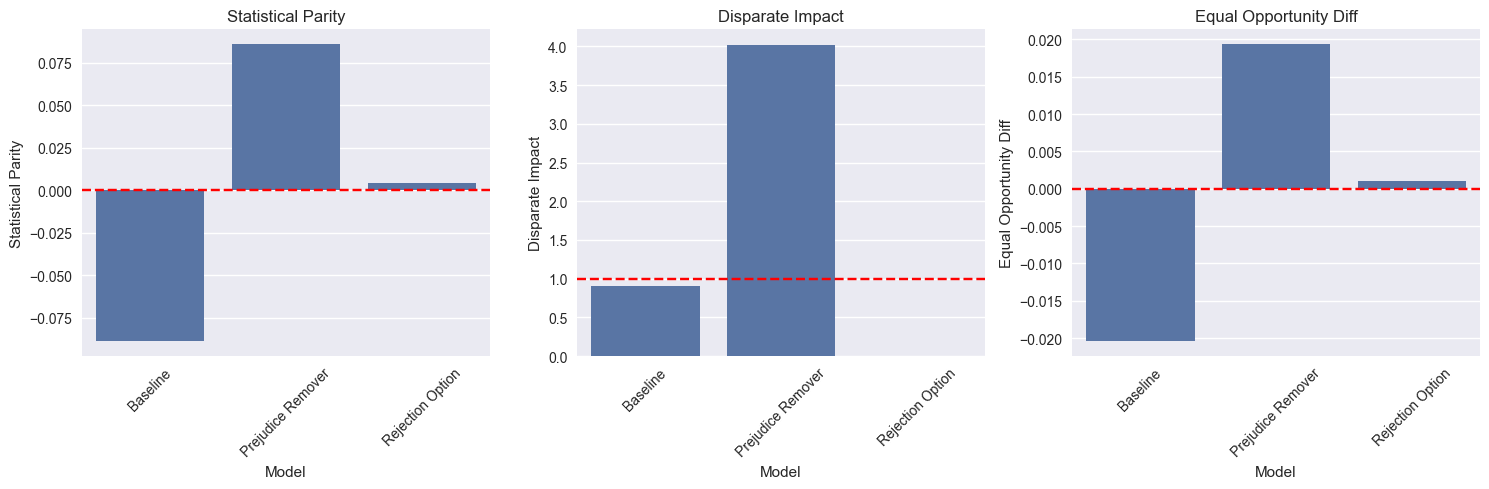

In [37]:
# Baseline model (no fairness intervention)
y_pred = model.predict(X_test)

# Create a DataFrame with X_test and y_pred to check for and handle missing values
test_results_df = pd.concat([X_test, pd.Series(y_pred, index=X_test.index, name='label_pred')], axis=1)

# Identify columns to check for NaNs. Include all feature columns from X_test and the predicted label column.
cols_to_check_nan = list(X_test.columns) + ['label_pred']

# Drop rows with missing values from this combined DataFrame
test_results_df_cleaned = test_results_df.dropna(subset=cols_to_check_nan).copy()

# Separate the cleaned X_test and y_pred
X_test_cleaned = test_results_df_cleaned[X_test.columns]
y_pred_cleaned = test_results_df_cleaned['label_pred'].astype(int) # Ensure predicted labels are integers

# Align y_test with the cleaned X_test_cleaned indices
y_test_cleaned = y_test.loc[X_test_cleaned.index]


# Convert cleaned test data and predictions to AIF360 format for baseline metric calculation
# Note: The BinaryLabelDataset needs the actual labels (y_test_cleaned) and the predicted labels (y_pred_cleaned)
# The first argument to ClassificationMetric is the original dataset with true labels,
# and the second argument is a dataset-like object with predicted labels.

# Create a BinaryLabelDataset for the true labels on the cleaned test data
test_dataset_cleaned = BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=pd.concat([X_test_cleaned, y_test_cleaned.rename('label')], axis=1), # Combine cleaned features and true labels
    label_names=['label'],
    protected_attribute_names=['race_Caucasian'], # Assuming race_Caucasian is the protected attribute in X_test
    unprivileged_protected_attributes=[0] # Assuming 0 represents the unprivileged group for race_Caucasian
)

# Create a BinaryLabelDataset for the predicted labels on the cleaned test data
pred_dataset_baseline = BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=pd.concat([X_test_cleaned, y_pred_cleaned.rename('label')], axis=1), # Combine cleaned features and predicted labels
    label_names=['label'],
    protected_attribute_names=['race_Caucasian'], # Assuming race_Caucasian is the protected attribute in X_test
    unprivileged_protected_attributes=[0] # Assuming 0 represents the unprivileged group for race_Caucasian
)


base_metric = ClassificationMetric(
    test_dataset_cleaned, # True labels
    pred_dataset_baseline, # Predicted labels
    unprivileged_groups=unprivileged_groups, # Use the unprivileged groups defined earlier (from previous cells)
    privileged_groups=privileged_groups # Use the privileged groups defined earlier (from previous cells)
)

# Create comparison dataframe
# Need to make sure classified_metric and roc_metric are accessible and refer to the appropriate metrics
# from the previous cells' executions. Assuming they are in the current scope.
results = pd.DataFrame({
    'Model': ['Baseline', 'Prejudice Remover', 'Rejection Option'],
    'Accuracy': [base_metric.accuracy(), classified_metric.accuracy(), roc_metric.accuracy()],
    'Statistical Parity': [base_metric.statistical_parity_difference(),
                          classified_metric.statistical_parity_difference(),
                          roc_metric.statistical_parity_difference()],
    'Disparate Impact': [base_metric.disparate_impact(),
                        classified_metric.disparate_impact(),
                        roc_metric.disparate_impact()],
    'Equal Opportunity Diff': [base_metric.equal_opportunity_difference(),
                              classified_metric.equal_opportunity_difference(),
                              roc_metric.equal_opportunity_difference()]
})

# Display results
print(results)

# Visualization
plt.figure(figsize=(15, 5))
metrics_to_plot = ['Statistical Parity', 'Disparate Impact', 'Equal Opportunity Diff']
for i, metric_name in enumerate(metrics_to_plot):
    plt.subplot(1, 3, i+1)
    sns.barplot(x='Model', y=metric_name, data=results)
    plt.title(metric_name)
    plt.xticks(rotation=45)
    # Adjust horizontal line based on metric meaning
    hline_value = 0 if metric_name in ['Statistical Parity', 'Equal Opportunity Diff'] else 1
    plt.axhline(y=hline_value, color='r', linestyle='--')

plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   The analysis revealed significant disparities in the model's prediction errors across different racial groups.
*   African-Americans had a False Positive Rate of 0.295, meaning approximately 29.5\% of African-Americans who did not recidivate were incorrectly predicted to do so. This rate was notably higher than for Caucasians (0.150), Hispanics (0.084), and the 'Other' group (0.091).
*   Caucasian, Hispanic, and 'Other' groups had higher False Negative Rates (0.562, 0.765, and 0.852 respectively) compared to African-Americans (0.320). This indicates the model was more likely to incorrectly predict no recidivism for individuals in these groups who actually recidivated.
*   The True Positive Rate (recall) for African-Americans was 0.680, higher than for Caucasians (0.438), Hispanics (0.235), and 'Other' (0.148), indicating the model was better at identifying actual recidivists in the African-American group.
*   The True Negative Rate (specificity) was higher for Caucasians (0.850), Hispanics (0.916), and 'Other' (0.909) compared to African-Americans (0.705), suggesting the model was better at identifying actual non-recidivists in these groups.
*   Due to very small sample sizes, the rates for Asian and Native American groups are less reliable, but they also suggest potential disparities (e.g., Native Americans had a very high False Positive Rate of 0.500).

### Insights or Next Steps

*   The analysis clearly indicates racial bias in the model's predictions, with different types of errors disproportionately affecting different racial groups. African-Americans are more likely to be incorrectly labeled as high risk, while other groups are more likely to be incorrectly labeled as low risk.
*   Further investigation is needed to understand the root causes of this bias, potentially involving an analysis of the features used by the model and their correlation with race. Debiasing techniques should be explored and applied to mitigate these disparities and ensure fairer predictions across all racial groups.
